<a href="https://colab.research.google.com/github/ddooley77/BH_AI/blob/main/EnhancedKnnLab_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔒 kNN Security Lab: Interactive Attacks and Defenses

## 🎯 Learning Objectives
By the end of this lab, you will:
1. **Understand** why kNN's distance-based nature creates unique vulnerabilities
2. **Implement** 5+ types of attacks against kNN models with visual demonstrations
3. **Evaluate** security-accuracy trade-offs quantitatively
4. **Design** robust kNN systems with appropriate defenses

## ⏱️ Lab Structure (60 minutes)
- **Part 1**: Interactive kNN Fundamentals (10 min)
- **Part 2**: Attack Demonstrations (30 min)
- **Part 3**: Defense Mechanisms (15 min)
- **Part 4**: Production Security (5 min)

---

In [1]:
!pip install -U plotly
import plotly.io as pio
pio.renderers.default = 'colab'

In [2]:
# 🛠️ Setup and Imports
!pip install numpy matplotlib ipywidgets scikit-learn plotly -q

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Custom color schemes for better visualization
COLORS = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
ATTACK_COLOR = '#FF6B6B'
DEFENSE_COLOR = '#4ECDC4'
CLEAN_COLOR = '#45B7D1'

## Part 1: Interactive kNN Fundamentals 🎓

### Understanding kNN Through Interactive Visualization

k-Nearest Neighbors is like asking your neighbors for advice:
- You look at the **k closest** data points
- They "vote" on what class the new point should be
- Majority wins!

**Security Insight**: This voting mechanism creates unique vulnerabilities - if an attacker can influence who your "neighbors" are, they control the vote!

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
import ipywidgets as widgets
from IPython.display import display, clear_output

# Generate data
np.random.seed(42)
X, y = make_blobs(n_samples=50, centers=2, n_features=2,
                  center_box=(-4, 4), random_state=42)

# Calculate bounds
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

def create_dynamic_knn_demo():
    """Create kNN demo with dynamic slider updates"""

    # Create output widgets
    plot_output = widgets.Output()
    info_output = widgets.Output()

    # Create control widgets
    k_slider = widgets.IntSlider(
        value=3, min=1, max=15, step=2,
        description='k value:',
        continuous_update=True,  # Enable continuous updates
        layout=widgets.Layout(width='400px')
    )

    x_slider = widgets.FloatSlider(
        value=0.0, min=x_min, max=x_max, step=0.1,
        description='Test X:',
        continuous_update=True,  # Enable continuous updates
        layout=widgets.Layout(width='400px'),
        readout_format='.1f'
    )

    y_slider = widgets.FloatSlider(
        value=0.0, min=y_min, max=y_max, step=0.1,
        description='Test Y:',
        continuous_update=True,  # Enable continuous updates
        layout=widgets.Layout(width='400px'),
        readout_format='.1f'
    )

    show_neighbors = widgets.Checkbox(
        value=True,
        description='Show Neighbors'
    )

    def update_plot(*args):
        """Update plot based on current slider values"""
        with plot_output:
            clear_output(wait=True)

            # Get current values
            k = k_slider.value
            test_x = x_slider.value
            test_y = y_slider.value
            show_n = show_neighbors.value

            # Create figure
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

            # Train KNN
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X, y)

            # Create decision boundary
            h = 0.1
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                               np.arange(y_min, y_max, h))
            Z = knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

            # Plot decision boundaries
            ax1.contourf(xx, yy, Z, alpha=0.4, cmap='RdBu', levels=[0, 0.5, 1])
            ax2.contourf(xx, yy, Z, alpha=0.4, cmap='RdBu', levels=[0, 0.5, 1])

            # Plot training points
            for i in range(2):
                mask = y == i
                color = 'darkred' if i == 0 else 'darkblue'
                ax1.scatter(X[mask, 0], X[mask, 1], c=color, s=50,
                           edgecolor='black', label=f'Class {i}')
                ax2.scatter(X[mask, 0], X[mask, 1], c=color, s=50,
                           edgecolor='black')

            # Make prediction
            test_point = np.array([[test_x, test_y]])
            prediction = knn.predict(test_point)[0]
            distances, indices = knn.kneighbors(test_point)
            neighbors = X[indices[0]]
            neighbor_classes = y[indices[0]]

            # Plot test point
            test_color = 'red' if prediction == 0 else 'blue'
            ax2.scatter(test_x, test_y, c='yellow', s=500, marker='*',
                       edgecolor='black', linewidth=2, zorder=5)

            # Add crosshairs for test point
            ax2.axhline(y=test_y, color='gray', linestyle=':', alpha=0.3, linewidth=1)
            ax2.axvline(x=test_x, color='gray', linestyle=':', alpha=0.3, linewidth=1)

            # Show neighbors if enabled
            if show_n:
                # Draw lines to neighbors
                for neighbor in neighbors:
                    ax2.plot([test_x, neighbor[0]], [test_y, neighbor[1]],
                            'green', alpha=0.6, linewidth=2, linestyle='--')

                # Highlight neighbors
                for i, (neighbor, nclass) in enumerate(zip(neighbors, neighbor_classes)):
                    circle = Circle((neighbor[0], neighbor[1]), 0.25,
                                  fill=False, edgecolor='green', linewidth=2.5)
                    ax2.add_patch(circle)

            # Set titles
            ax1.set_title(f'Decision Boundary (k={k})', fontsize=14)
            ax2.set_title(f'Test Point Classification: Class {prediction}', fontsize=14)

            # Set labels and limits
            for ax in [ax1, ax2]:
                ax.set_xlabel('Feature 1')
                ax.set_ylabel('Feature 2')
                ax.set_xlim(x_min, x_max)
                ax.set_ylim(y_min, y_max)
                ax.grid(True, alpha=0.3)

            ax1.legend()

            plt.tight_layout()
            plt.show()

        # Update info display
        with info_output:
            clear_output(wait=True)
            votes = [np.sum(neighbor_classes == i) for i in range(2)]

            print(f"📍 Test Point: ({test_x:.2f}, {test_y:.2f})")
            print(f"🎯 Predicted Class: {prediction}")
            print(f"🗳️  Votes: Class 0 (Red) = {votes[0]}, Class 1 (Blue) = {votes[1]}")
            print(f"🔐 Security: Need {k//2 + 1} neighbors to flip prediction")

    # Connect sliders to update function
    k_slider.observe(update_plot, names='value')
    x_slider.observe(update_plot, names='value')
    y_slider.observe(update_plot, names='value')
    show_neighbors.observe(update_plot, names='value')

    # Create layout
    controls = widgets.VBox([
        widgets.HTML("<h3>🎮 k-Nearest Neighbors Interactive Demo</h3>"),
        k_slider,
        x_slider,
        y_slider,
        show_neighbors
    ])

    # Display everything
    display(widgets.VBox([controls, plot_output, info_output]))

    # Initial plot
    update_plot()

# Run the demo
create_dynamic_knn_demo()

### 📐 Distance Metrics: The Heart of kNN Security

kNN relies on distance to find neighbors. Different metrics create different vulnerabilities!

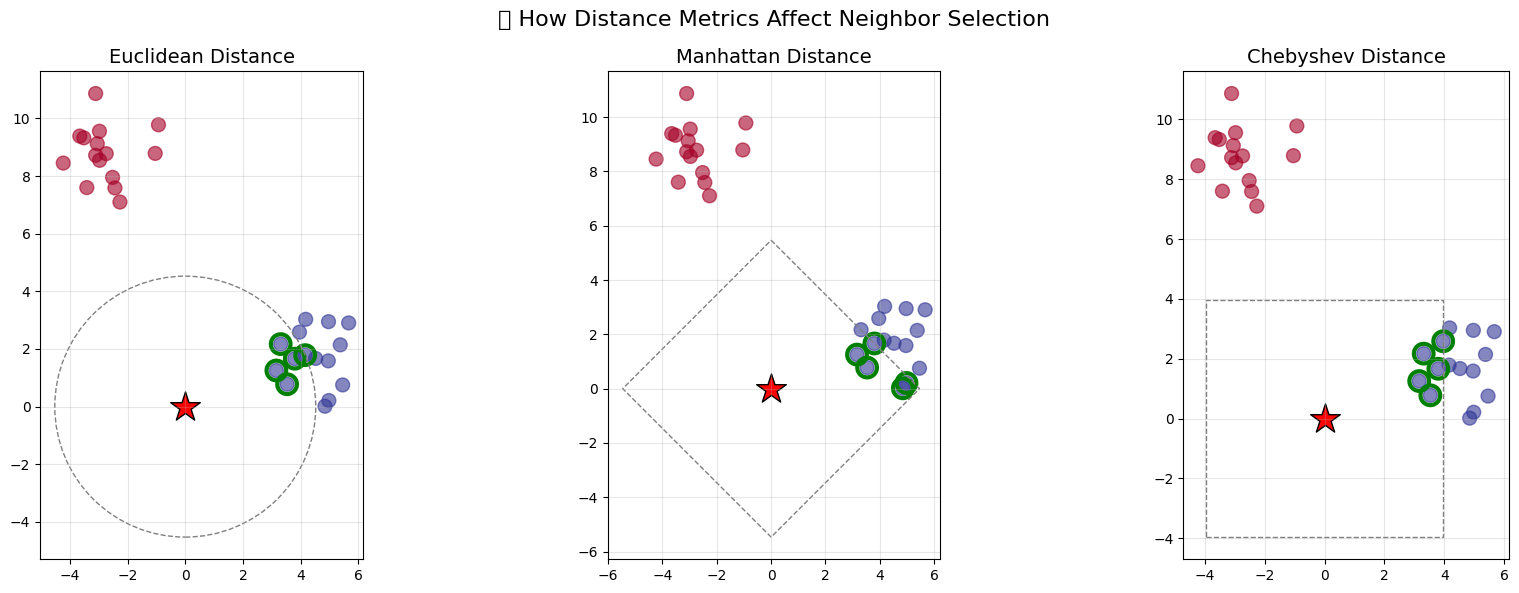


⚠️ Security Note: Different ways of measuring distance have different weaknesses!
  Please note which traning points are used as the nearest neighbors when using different distance metrics.
- Euclidean (straight line): An attacker can make small changes in any direction to fool the system
- Manhattan (city blocks): An attacker gets better results by moving straight up/down or left/right
- Chebyshev (maximum): An attacker only needs to change ONE thing by a lot to trick the system


In [4]:
# 📊 Interactive Distance Metric Comparison
def visualize_distance_metrics():
    """Show how different distance metrics affect neighbor selection"""

    # Generate data
    X, y = make_blobs(n_samples=30, centers=2, random_state=42)
    test_point = np.array([[0, 0]])

    metrics = ['euclidean', 'manhattan', 'chebyshev']
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for idx, (ax, metric) in enumerate(zip(axes, metrics)):
        # Train kNN with different metric
        knn = KNeighborsClassifier(n_neighbors=5, metric=metric)
        knn.fit(X, y)

        # Get neighbors
        distances, indices = knn.kneighbors(test_point)
        neighbors = X[indices[0]]

        # Plot
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu', s=100, alpha=0.6)
        ax.scatter(test_point[0, 0], test_point[0, 1],
                  c='red', marker='*', s=500, edgecolor='black')

        # Highlight neighbors
        ax.scatter(neighbors[:, 0], neighbors[:, 1],
                  s=200, facecolors='none', edgecolors='green', linewidth=3)

        # Draw distance circles/squares
        if metric == 'euclidean':
            circle = plt.Circle(test_point[0], distances[0, -1],
                              fill=False, color='gray', linestyle='--')
            ax.add_patch(circle)
        elif metric == 'manhattan':
            # Draw diamond for Manhattan distance
            d = distances[0, -1]
            diamond = plt.Polygon([(test_point[0, 0], test_point[0, 1] + d),
                                 (test_point[0, 0] + d, test_point[0, 1]),
                                 (test_point[0, 0], test_point[0, 1] - d),
                                 (test_point[0, 0] - d, test_point[0, 1])],
                                fill=False, edgecolor='gray', linestyle='--')
            ax.add_patch(diamond)
        else:  # chebyshev
            d = distances[0, -1]
            square = plt.Rectangle((test_point[0, 0] - d, test_point[0, 1] - d),
                                 2*d, 2*d, fill=False, color='gray', linestyle='--')
            ax.add_patch(square)

        ax.set_title(f'{metric.capitalize()} Distance', fontsize=14)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)

    plt.suptitle('🎯 How Distance Metrics Affect Neighbor Selection', fontsize=16)
    plt.tight_layout()
    plt.show()

    print("\n⚠️ Security Note: Different ways of measuring distance have different weaknesses!")
    print("  Please note which traning points are used as the nearest neighbors when using different distance metrics.")
    print("- Euclidean (straight line): An attacker can make small changes in any direction to fool the system")
    print("- Manhattan (city blocks): An attacker gets better results by moving straight up/down or left/right")
    print("- Chebyshev (maximum): An attacker only needs to change ONE thing by a lot to trick the system")

visualize_distance_metrics()

## Part 2: Attack Demonstrations 🗡️

Now let's see how attackers can exploit kNN's vulnerabilities. We'll demonstrate 5 major attack types with interactive visualizations.

### Attack 1: Strategic Label Flipping 🔄

Instead of randomly flipping labels, smart attackers target points near decision boundaries for maximum impact.

🔬 LABEL FLIPPING ATTACK DEMONSTRATION
Attack Type: Training Data Poisoning
Attack Goal: Degrade model performance by corrupting labels
Attack Method: Flip labels of carefully selected training points



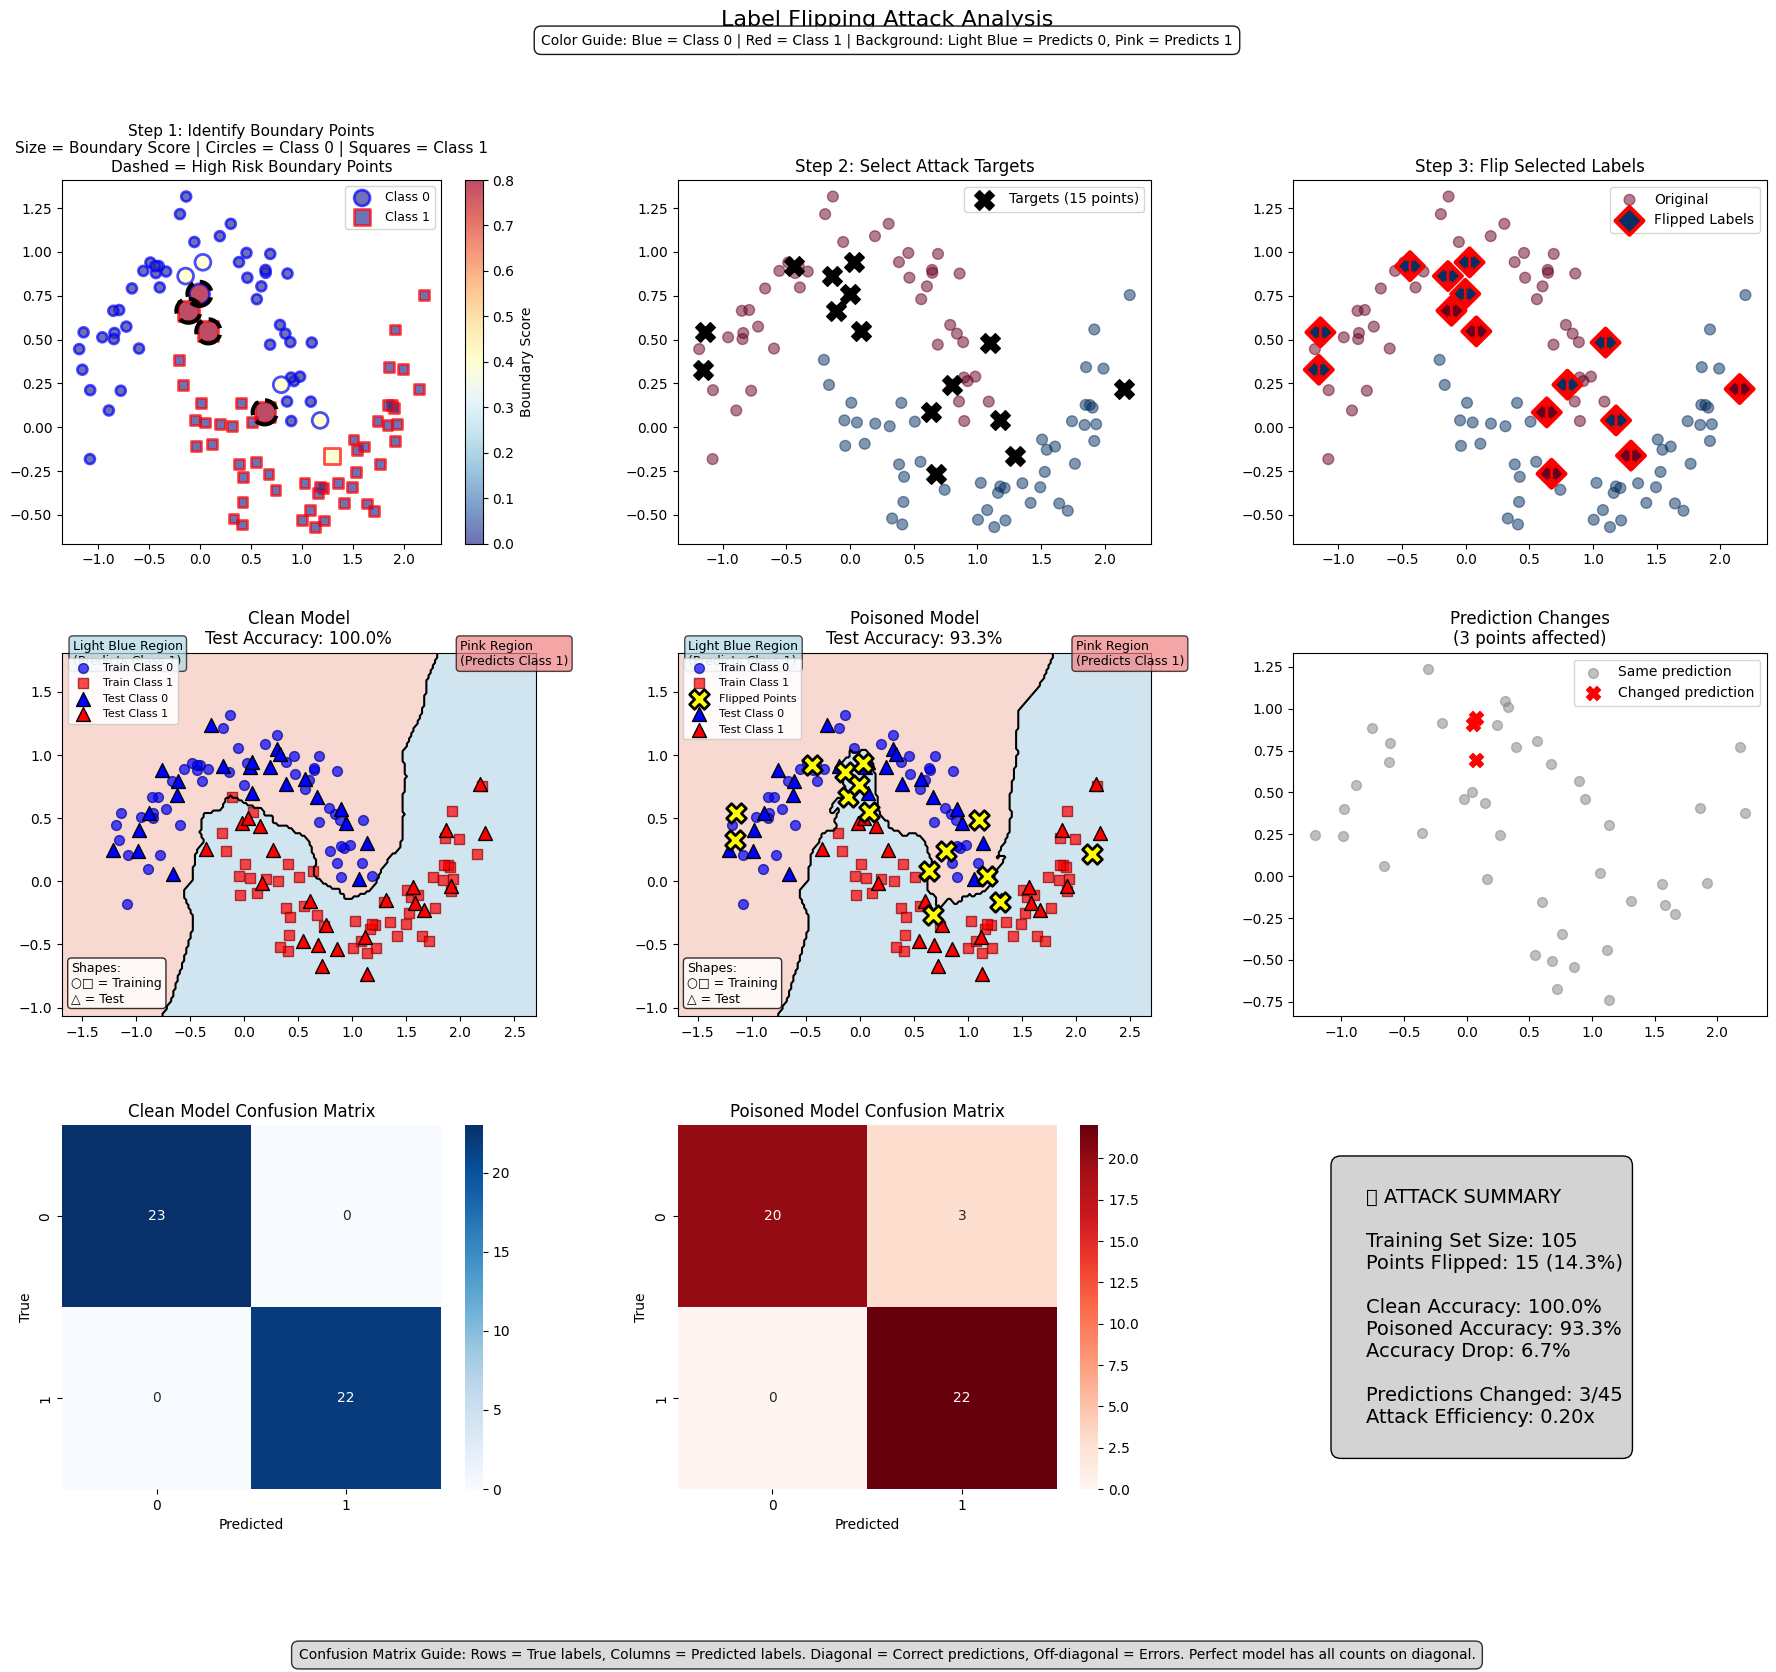


📊 COMPARING ATTACK STRATEGIES

Attack efficiency measures how many test predictions change per flipped training point.

RANDOM Strategy:
  Clean accuracy: 100.0%
  Poisoned accuracy: 97.8%
  Accuracy drop: 2.2%
  Attack efficiency: 1.5% per point

BOUNDARY Strategy:
  Clean accuracy: 100.0%
  Poisoned accuracy: 93.3%
  Accuracy drop: 6.7%
  Attack efficiency: 4.4% per point

CLUSTER_CENTER Strategy:
  Clean accuracy: 100.0%
  Poisoned accuracy: 80.0%
  Accuracy drop: 20.0%
  Attack efficiency: 13.3% per point


    🚨 SECURITY RISKS OF LABEL FLIPPING ATTACKS

    HOW THE ATTACK WORKS:
    --------------------
    1. GAIN ACCESS: Attacker gets access to training data BEFORE model training
       - Insider with database access
       - Compromised data annotation service
       - Malicious crowdworker

    2. IDENTIFY TARGETS: Find most impactful points to corrupt
       - Boundary points (mixed neighborhoods)
       - High-influence samples
       - Critical decision regions

    3. FLI

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# 🎯 Strategic Label Flipping Attack - Enhanced Version
class StrategicLabelFlippingAttack:
    """
    Label flipping attack that targets boundary points to maximize classifier confusion.
    """
    def __init__(self, X_train, y_train, k=5):
        self.X_train = X_train
        self.y_train = y_train
        self.k = k
        self.knn = KNeighborsClassifier(n_neighbors=k)
        self.knn.fit(X_train, y_train)

    def find_boundary_points(self, threshold=0.7):
        """
        Find points near decision boundary (most vulnerable to flipping).
        Points with ~50/50 neighbor split are on the boundary.
        """
        boundary_scores = []

        for i, x in enumerate(self.X_train):
            # Get k+1 neighbors (including self)
            distances, indices = self.knn.kneighbors(x.reshape(1, -1),
                                                    n_neighbors=self.k+1)
            neighbor_indices = indices[0][1:]  # Exclude self
            neighbor_labels = self.y_train[neighbor_indices]

            # Calculate proportion of neighbors with same label as point
            same_label_ratio = np.mean(neighbor_labels == self.y_train[i])

            # Boundary points have mixed neighborhoods (ratio close to 0.5)
            boundary_score = 1 - abs(same_label_ratio - 0.5) * 2
            boundary_scores.append(boundary_score)

        return np.array(boundary_scores)

    def select_attack_points(self, flip_ratio=0.1, strategy='boundary'):
        """
        Select points to flip based on attack strategy.
        """
        n_flip = int(len(self.y_train) * flip_ratio)

        if strategy == 'boundary':
            # Target boundary points (most effective)
            scores = self.find_boundary_points()
            flip_indices = np.argsort(scores)[-n_flip:]
        elif strategy == 'random':
            # Random selection (baseline)
            flip_indices = np.random.choice(len(self.y_train), n_flip, replace=False)
        elif strategy == 'cluster_center':
            # Target points in center of clusters (most damaging)
            scores = self.calculate_centrality_scores()
            flip_indices = np.argsort(scores)[-n_flip:]

        return flip_indices

    def calculate_centrality_scores(self):
        """
        Find points that are central to their class clusters.
        """
        centrality_scores = []

        for i, x in enumerate(self.X_train):
            # Find same-class neighbors
            same_class_mask = self.y_train == self.y_train[i]
            same_class_points = self.X_train[same_class_mask]

            # Calculate average distance to same-class points
            if len(same_class_points) > 1:
                distances = np.linalg.norm(same_class_points - x, axis=1)
                avg_distance = np.mean(distances[distances > 0])  # Exclude self
                centrality_scores.append(1 / (avg_distance + 1e-6))
            else:
                centrality_scores.append(0)

        return np.array(centrality_scores)

    def attack(self, flip_ratio=0.1, strategy='boundary'):
        """
        Execute label flipping attack.
        """
        flip_indices = self.select_attack_points(flip_ratio, strategy)

        # Create poisoned labels
        y_poisoned = self.y_train.copy()
        y_poisoned[flip_indices] = 1 - y_poisoned[flip_indices]

        return y_poisoned, flip_indices

# Enhanced visualization function
def visualize_boundary_explanation(ax, X_train, y_train, attacker):
    """
    Show WHY certain points are boundary points by visualizing their neighborhoods.
    """
    # Find the highest boundary score points
    boundary_scores = attacker.find_boundary_points()
    top_boundary_indices = np.argsort(boundary_scores)[-3:]  # Top 3 boundary points

    # Plot all points with class colors
    class_0_mask = y_train == 0
    class_1_mask = y_train == 1

    ax.scatter(X_train[class_0_mask, 0], X_train[class_0_mask, 1],
              c='blue', s=30, alpha=0.3, marker='o', label='Class 0')
    ax.scatter(X_train[class_1_mask, 0], X_train[class_1_mask, 1],
              c='red', s=30, alpha=0.3, marker='s', label='Class 1')

    # For each top boundary point, show its neighbors
    for idx in top_boundary_indices:
        point = X_train[idx]

        # Get neighbors
        distances, indices = attacker.knn.kneighbors(point.reshape(1, -1),
                                                    n_neighbors=attacker.k+1)
        neighbor_indices = indices[0][1:]  # Exclude self

        # Draw connections to neighbors
        for n_idx in neighbor_indices:
            neighbor = X_train[n_idx]
            ax.plot([point[0], neighbor[0]], [point[1], neighbor[1]],
                   'gray', alpha=0.5, linewidth=1, zorder=1)

        # Highlight the boundary point
        marker = 'o' if y_train[idx] == 0 else 's'
        color = 'blue' if y_train[idx] == 0 else 'red'
        ax.scatter(point[0], point[1], c=color, s=300,
                  marker=marker, edgecolor='black', linewidth=3, zorder=3)

        # Count neighbor classes
        neighbor_labels = y_train[neighbor_indices]
        class_0_count = np.sum(neighbor_labels == 0)
        class_1_count = np.sum(neighbor_labels == 1)

        # Add text showing neighbor composition
        ax.annotate(f'{class_0_count}|{class_1_count}',
                   xy=(point[0], point[1]), xytext=(5, 5),
                   textcoords='offset points', fontsize=10,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

    ax.set_title('Why Boundary Points?\n' +
                'Boundary points have mixed neighbors (shown as #blue|#red)\n' +
                'Lines connect to k=5 nearest neighbors', fontsize=11)
    ax.legend(loc='upper right', fontsize=9)

def visualize_attack_process(X_train, y_train, y_poisoned, flip_indices,
                           X_test, y_test, attacker):
    """
    Create comprehensive visualization of the attack process.
    """
    fig = plt.figure(figsize=(22, 17))

    # Create grid layout
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    # 1. Original data with boundary scores
    ax1 = fig.add_subplot(gs[0, 0])
    boundary_scores = attacker.find_boundary_points()

    # Plot class 0 points
    class_0_mask = y_train == 0
    class_1_mask = y_train == 1

    # Use different markers for different classes
    # Size represents boundary score
    sizes = 50 + boundary_scores * 200  # Scale sizes based on boundary score

    # Plot class 0 as circles
    scatter1 = ax1.scatter(X_train[class_0_mask, 0], X_train[class_0_mask, 1],
                          c=boundary_scores[class_0_mask], cmap='RdYlBu_r',
                          s=sizes[class_0_mask], marker='o',
                          edgecolor='blue', linewidth=2, alpha=0.7,
                          label='Class 0')

    # Plot class 1 as squares
    scatter2 = ax1.scatter(X_train[class_1_mask, 0], X_train[class_1_mask, 1],
                          c=boundary_scores[class_1_mask], cmap='RdYlBu_r',
                          s=sizes[class_1_mask], marker='s',
                          edgecolor='red', linewidth=2, alpha=0.7,
                          label='Class 1')

    # Add colorbar
    cbar = plt.colorbar(scatter1, ax=ax1, label='Boundary Score')

    # Highlight high boundary score points
    high_boundary = boundary_scores > 0.7
    ax1.scatter(X_train[high_boundary, 0], X_train[high_boundary, 1],
               s=300, facecolors='none', edgecolors='black',
               linewidths=3, linestyles='dashed')

    ax1.set_title('Step 1: Identify Boundary Points\n' +
                  'Size = Boundary Score | Circles = Class 0 | Squares = Class 1\n' +
                  'Dashed = High Risk Boundary Points', fontsize=11)
    ax1.legend(loc='upper right', fontsize=9)

    # 2. Attack targets
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.scatter(X_train[:, 0], X_train[:, 1], c=y_train,
               cmap='RdBu', s=60, alpha=0.5)
    ax2.scatter(X_train[flip_indices, 0], X_train[flip_indices, 1],
               s=200, marker='X', c='black',
               label=f'Targets ({len(flip_indices)} points)')
    ax2.set_title('Step 2: Select Attack Targets', fontsize=12)
    ax2.legend()

    # 3. Before/After comparison
    ax3 = fig.add_subplot(gs[0, 2])
    # Show original labels for flipped points
    for idx in flip_indices:
        ax3.annotate('', xy=(X_train[idx, 0], X_train[idx, 1] + 0.1),
                    xytext=(X_train[idx, 0], X_train[idx, 1] - 0.1),
                    arrowprops=dict(arrowstyle='<->', color='red', lw=2))
    ax3.scatter(X_train[:, 0], X_train[:, 1], c=y_train,
               cmap='RdBu', s=60, alpha=0.5, label='Original')
    ax3.scatter(X_train[flip_indices, 0], X_train[flip_indices, 1],
               c=y_poisoned[flip_indices], cmap='RdBu', s=200,
               marker='D', edgecolor='red', linewidth=3,
               label='Flipped Labels')
    ax3.set_title('Step 3: Flip Selected Labels', fontsize=12)
    ax3.legend()

    # 4-5. Decision boundaries
    knn_clean = KNeighborsClassifier(n_neighbors=5)
    knn_clean.fit(X_train, y_train)

    knn_poisoned = KNeighborsClassifier(n_neighbors=5)
    knn_poisoned.fit(X_train, y_poisoned)

    ax4 = fig.add_subplot(gs[1, 0])
    plot_decision_boundary(ax4, knn_clean, X_train, y_train,
                          X_test, y_test, 'Clean Model')

    ax5 = fig.add_subplot(gs[1, 1])
    plot_decision_boundary(ax5, knn_poisoned, X_train, y_poisoned,
                          X_test, y_test, 'Poisoned Model',
                          highlight_flipped=flip_indices)

    # 6. Prediction differences
    ax6 = fig.add_subplot(gs[1, 2])
    clean_pred = knn_clean.predict(X_test)
    poisoned_pred = knn_poisoned.predict(X_test)
    mismatched = clean_pred != poisoned_pred

    ax6.scatter(X_test[~mismatched, 0], X_test[~mismatched, 1],
               c='gray', s=50, alpha=0.5, label='Same prediction')
    ax6.scatter(X_test[mismatched, 0], X_test[mismatched, 1],
               c='red', s=100, marker='X', label='Changed prediction')
    ax6.set_title(f'Prediction Changes\n({np.sum(mismatched)} points affected)',
                 fontsize=12)
    ax6.legend()

    # 7-8. Confusion matrices
    ax7 = fig.add_subplot(gs[2, 0])
    cm_clean = confusion_matrix(y_test, clean_pred)
    sns.heatmap(cm_clean, annot=True, fmt='d', cmap='Blues', ax=ax7)
    ax7.set_title('Clean Model Confusion Matrix', fontsize=12)
    ax7.set_xlabel('Predicted')
    ax7.set_ylabel('True')

    ax8 = fig.add_subplot(gs[2, 1])
    cm_poisoned = confusion_matrix(y_test, poisoned_pred)
    sns.heatmap(cm_poisoned, annot=True, fmt='d', cmap='Reds', ax=ax8)
    ax8.set_title('Poisoned Model Confusion Matrix', fontsize=12)
    ax8.set_xlabel('Predicted')
    ax8.set_ylabel('True')

    # 9. Attack summary
    ax9 = fig.add_subplot(gs[2, 2])
    ax9.axis('off')

    acc_clean = accuracy_score(y_test, clean_pred)
    acc_poisoned = accuracy_score(y_test, poisoned_pred)

    summary_text = f"""
    🎯 ATTACK SUMMARY

    Training Set Size: {len(y_train)}
    Points Flipped: {len(flip_indices)} ({len(flip_indices)/len(y_train)*100:.1f}%)

    Clean Accuracy: {acc_clean*100:.1f}%
    Poisoned Accuracy: {acc_poisoned*100:.1f}%
    Accuracy Drop: {(acc_clean-acc_poisoned)*100:.1f}%

    Predictions Changed: {np.sum(mismatched)}/{len(y_test)}
    Attack Efficiency: {np.sum(mismatched)/len(flip_indices):.2f}x
    """

    ax9.text(0.1, 0.5, summary_text, fontsize=14,
            verticalalignment='center',
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray"))

    plt.suptitle('Label Flipping Attack Analysis', fontsize=16, y=0.98)

    # Add overall color guide
    fig.text(0.5, 0.96,
            'Color Guide: Blue = Class 0 | Red = Class 1 | Background: Light Blue = Predicts 0, Pink = Predicts 1',
            ha='center', fontsize=10,
            bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="black", alpha=0.9))

    # Add confusion matrix explanation
    fig.text(0.5, 0.01,
            'Confusion Matrix Guide: Rows = True labels, Columns = Predicted labels. ' +
            'Diagonal = Correct predictions, Off-diagonal = Errors. ' +
            'Perfect model has all counts on diagonal.',
            ha='center', fontsize=10,
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
    return fig

def plot_decision_boundary(ax, model, X_train, y_train, X_test, y_test,
                          title, highlight_flipped=None):
    """Enhanced decision boundary plotting with clear legends."""
    x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
    y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot decision regions with correct labels
    contourf = ax.contourf(xx, yy, Z, alpha=0.3, cmap='RdBu', levels=1)
    ax.contour(xx, yy, Z, colors='black', linewidths=1.5, levels=[0.5])

    # Determine which region is which by checking a few points
    # Check left side of plot
    left_prediction = model.predict([[x_min + 0.5, (y_min + y_max) / 2]])[0]
    # Check right side of plot
    right_prediction = model.predict([[x_max - 0.5, (y_min + y_max) / 2]])[0]

    # Place labels correctly based on actual predictions
    if left_prediction == 0:
        ax.text(x_min + 0.1, y_max - 0.1, 'Light Blue Region\n(Predicts Class 1)',
               fontsize=9, bbox=dict(boxstyle="round", facecolor="lightblue", alpha=0.7))
        ax.text(x_max - 0.7, y_max - 0.1, 'Pink Region\n(Predicts Class 1)',
               fontsize=9, bbox=dict(boxstyle="round", facecolor="lightcoral", alpha=0.7))
    else:
        ax.text(x_min + 0.1, y_max - 0.1, 'Pink Region\n(Predicts Class 0)',
               fontsize=9, bbox=dict(boxstyle="round", facecolor="lightcoral", alpha=0.7))
        ax.text(x_max - 0.7, y_max - 0.1, 'Light Blue Region\n(Predicts Class 0)',
               fontsize=9, bbox=dict(boxstyle="round", facecolor="lightblue", alpha=0.7))

    # Plot training points (circles and squares)
    train_0 = ax.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1],
                        c='blue', marker='o', s=50, alpha=0.7,
                        edgecolor='darkblue', label='Train Class 0')
    train_1 = ax.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1],
                        c='red', marker='s', s=50, alpha=0.7,
                        edgecolor='darkred', label='Train Class 1')

    # Highlight flipped points with yellow X
    if highlight_flipped is not None:
        ax.scatter(X_train[highlight_flipped, 0], X_train[highlight_flipped, 1],
                  s=200, marker='X', c='yellow', edgecolor='black',
                  linewidth=2, label='Flipped Points', zorder=5)

    # Plot test points (triangles)
    test_0 = ax.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1],
                       c='blue', marker='^', s=100, edgecolor='black',
                       label='Test Class 0')
    test_1 = ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1],
                       c='red', marker='^', s=100, edgecolor='black',
                       label='Test Class 1')

    acc = accuracy_score(y_test, model.predict(X_test))
    ax.set_title(f'{title}\nTest Accuracy: {acc*100:.1f}%', fontsize=12)

    # Add legend with clear descriptions
    ax.legend(loc='upper left', fontsize=8, framealpha=0.9)

    # Add shape legend
    ax.text(0.02, 0.15, 'Shapes:\n○□ = Training\n△ = Test',
            transform=ax.transAxes, fontsize=9,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
            verticalalignment='top')

# Main demonstration function
def demonstrate_label_flipping_attack():
    """
    Comprehensive demonstration of label flipping attacks.

    WHAT IS A LABEL FLIPPING ATTACK?
    ================================
    1. Attacker gains access to training data (before model training)
    2. Attacker identifies most impactful points to corrupt
    3. Attacker manually changes the labels of these points (0→1 or 1→0)
    4. Model is trained on this poisoned dataset
    5. Result: Model learns incorrect patterns and performs poorly

    This is a training-time attack, not a test-time attack!
    """
    print("🔬 LABEL FLIPPING ATTACK DEMONSTRATION")
    print("=" * 50)
    print("Attack Type: Training Data Poisoning")
    print("Attack Goal: Degrade model performance by corrupting labels")
    print("Attack Method: Flip labels of carefully selected training points")
    print("=" * 50 + "\n")

    # Generate more complex data for better demonstration
    X, y = make_moons(n_samples=150, noise=0.15, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # Create attacker
    attacker = StrategicLabelFlippingAttack(X_train, y_train, k=5)

    # Execute attack
    y_poisoned, flip_indices = attacker.attack(flip_ratio=0.15, strategy='boundary')

    # Create visualization
    fig = visualize_attack_process(X_train, y_train, y_poisoned, flip_indices,
                                 X_test, y_test, attacker)
    plt.show()

    # Compare different attack strategies
    print("\n📊 COMPARING ATTACK STRATEGIES\n")
    print("Attack efficiency measures how many test predictions change per flipped training point.\n")
    strategies = ['random', 'boundary', 'cluster_center']

    for strategy in strategies:
        y_poisoned, flip_indices = attacker.attack(flip_ratio=0.15, strategy=strategy)

        knn_clean = KNeighborsClassifier(n_neighbors=5)
        knn_clean.fit(X_train, y_train)

        knn_poisoned = KNeighborsClassifier(n_neighbors=5)
        knn_poisoned.fit(X_train, y_poisoned)

        acc_clean = accuracy_score(y_test, knn_clean.predict(X_test))
        acc_poisoned = accuracy_score(y_test, knn_poisoned.predict(X_test))

        print(f"{strategy.upper()} Strategy:")
        print(f"  Clean accuracy: {acc_clean*100:.1f}%")
        print(f"  Poisoned accuracy: {acc_poisoned*100:.1f}%")
        print(f"  Accuracy drop: {(acc_clean-acc_poisoned)*100:.1f}%")
        print(f"  Attack efficiency: {(acc_clean-acc_poisoned)/len(flip_indices)*1000:.1f}% per point\n")

# Security implications explanation
def explain_security_risks():
    """
    Explain the security risks and real-world implications of label flipping attacks.
    """
    print("""
    🚨 SECURITY RISKS OF LABEL FLIPPING ATTACKS
    ==========================================

    HOW THE ATTACK WORKS:
    --------------------
    1. GAIN ACCESS: Attacker gets access to training data BEFORE model training
       - Insider with database access
       - Compromised data annotation service
       - Malicious crowdworker

    2. IDENTIFY TARGETS: Find most impactful points to corrupt
       - Boundary points (mixed neighborhoods)
       - High-influence samples
       - Critical decision regions

    3. FLIP LABELS: Manually change labels (0→1, Yes→No, Malware→Benign)
       - No need to modify features, just labels
       - Small percentage can cause big impact
       - Hard to detect without auditing

    4. POISON TRAINING: Model learns from corrupted data
       - Learns wrong patterns
       - Decision boundaries shift
       - Performance degrades

    REAL-WORLD ATTACK SCENARIOS:
    ---------------------------

    a) Spam Filter Poisoning
       - Flip spam emails to "not spam"
       - Result: Spam gets through to users
       - Impact: Phishing attacks succeed

    b) Malware Detection Evasion
       - Flip malware samples to "benign"
       - Result: Malware bypasses detection
       - Impact: System compromise

    c) Medical Diagnosis Corruption
       - Flip disease labels in training data
       - Result: Misdiagnosis of patients
       - Impact: Life-threatening errors

    d) Financial Fraud Detection
       - Flip fraudulent transactions to "legitimate"
       - Result: Fraud goes undetected
       - Impact: Financial losses

    e) Content Moderation Bypass
       - Flip harmful content to "safe"
       - Result: Toxic content spreads
       - Impact: Platform safety compromised

    WHY ATTACKERS WANT THIS:
    -----------------------

    1. TARGETED ATTACKS
       - Make specific malicious samples bypass detection
       - Create blind spots in model's decision making
       - Enable future attacks to succeed

    2. ECONOMIC DAMAGE
       - Force expensive model retraining
       - Reduce customer trust
       - Create liability issues

    3. COMPETITIVE SABOTAGE
       - Degrade competitor's AI performance
       - Make their products unreliable
       - Damage their reputation

    DEFENSE STRATEGIES:
    ------------------

    1. DATA VALIDATION
       ✓ Multiple independent labelers
       ✓ Anomaly detection on labels
       ✓ Cross-validation checks
       ✓ Trusted data sources only

    2. ROBUST TRAINING
       ✓ Algorithms resistant to label noise
       ✓ Ensemble methods for verification
       ✓ Regular performance monitoring
       ✓ Outlier detection in training

    3. ACCESS CONTROL
       ✓ Limit who can modify training data
       ✓ Audit trail for all changes
       ✓ Version control on datasets
       ✓ Integrity checks

    4. DETECTION METHODS
       ✓ Statistical analysis of label distribution
       ✓ Monitor model confidence scores
       ✓ Track performance metrics over time
       ✓ Compare with baseline models

    KNN SPECIFIC VULNERABILITIES:
    ----------------------------
    • No model parameters = can't filter noise during training
    • Direct memorization of labels = every flip matters
    • Local decisions = easier to create targeted blind spots
    • Boundary sensitivity = small flips cause big changes

    ⚠️ REMEMBER: This is why ML systems need security-first design!
    Never assume training data is trustworthy in production systems.
    """)

# Run the demonstration
if __name__ == "__main__":
    demonstrate_label_flipping_attack()
    explain_security_risks()

### Attack 2: Model Extraction Attack 📋

Can we steal the entire model by querying it? With kNN, we can often reconstruct the training data!

🔬 LABEL FLIPPING ATTACK DEMONSTRATION



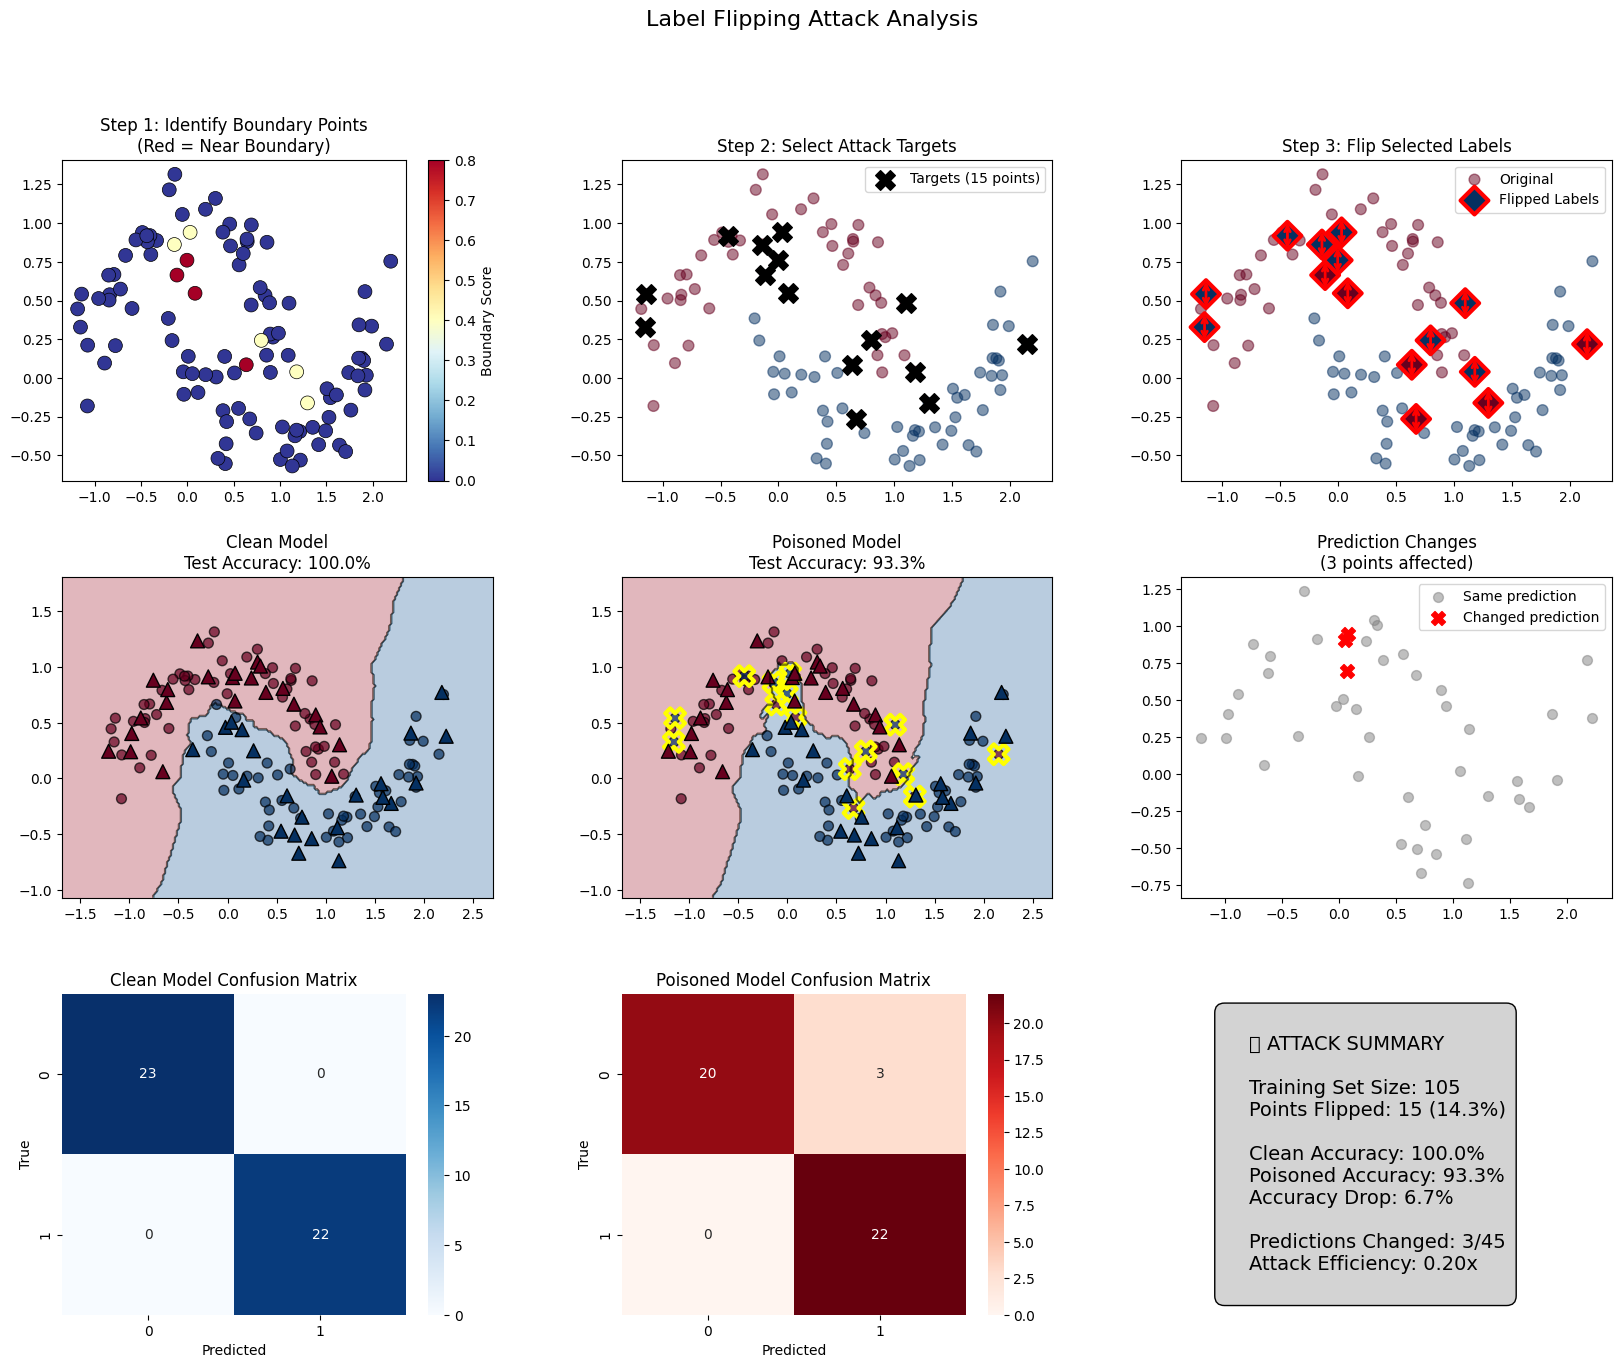


📊 COMPARING ATTACK STRATEGIES

RANDOM Strategy:
  Clean accuracy: 100.0%
  Poisoned accuracy: 91.1%
  Accuracy drop: 8.9%
  Attack efficiency: 5.9% per point

BOUNDARY Strategy:
  Clean accuracy: 100.0%
  Poisoned accuracy: 93.3%
  Accuracy drop: 6.7%
  Attack efficiency: 4.4% per point

CLUSTER_CENTER Strategy:
  Clean accuracy: 100.0%
  Poisoned accuracy: 80.0%
  Accuracy drop: 20.0%
  Attack efficiency: 13.3% per point


    🚨 SECURITY RISKS OF LABEL FLIPPING ATTACKS

    1. TRAINING DATA POISONING
       - Attackers with access to training data can corrupt model behavior
       - Even small amounts of poisoning (10-15%) can significantly degrade performance
       - Hard to detect without careful data auditing

    2. REAL-WORLD ATTACK SCENARIOS

       a) Crowdsourced Labeling Attacks
          - Many ML systems use crowdsourced labels (e.g., CAPTCHA, content moderation)
          - Malicious workers can intentionally mislabel data
          - Example: Flipping spam/not-spam labe

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# 🎯 Strategic Label Flipping Attack - Enhanced Version
class StrategicLabelFlippingAttack:
    """
    Label flipping attack that targets boundary points to maximize classifier confusion.
    """
    def __init__(self, X_train, y_train, k=5):
        self.X_train = X_train
        self.y_train = y_train
        self.k = k
        self.knn = KNeighborsClassifier(n_neighbors=k)
        self.knn.fit(X_train, y_train)

    def find_boundary_points(self, threshold=0.7):
        """
        Find points near decision boundary (most vulnerable to flipping).
        Points with ~50/50 neighbor split are on the boundary.
        """
        boundary_scores = []

        for i, x in enumerate(self.X_train):
            # Get k+1 neighbors (including self)
            distances, indices = self.knn.kneighbors(x.reshape(1, -1),
                                                    n_neighbors=self.k+1)
            neighbor_indices = indices[0][1:]  # Exclude self
            neighbor_labels = self.y_train[neighbor_indices]

            # Calculate proportion of neighbors with same label as point
            same_label_ratio = np.mean(neighbor_labels == self.y_train[i])

            # Boundary points have mixed neighborhoods (ratio close to 0.5)
            boundary_score = 1 - abs(same_label_ratio - 0.5) * 2
            boundary_scores.append(boundary_score)

        return np.array(boundary_scores)

    def select_attack_points(self, flip_ratio=0.1, strategy='boundary'):
        """
        Select points to flip based on attack strategy.
        """
        n_flip = int(len(self.y_train) * flip_ratio)

        if strategy == 'boundary':
            # Target boundary points (most effective)
            scores = self.find_boundary_points()
            flip_indices = np.argsort(scores)[-n_flip:]
        elif strategy == 'random':
            # Random selection (baseline)
            flip_indices = np.random.choice(len(self.y_train), n_flip, replace=False)
        elif strategy == 'cluster_center':
            # Target points in center of clusters (most damaging)
            scores = self.calculate_centrality_scores()
            flip_indices = np.argsort(scores)[-n_flip:]

        return flip_indices

    def calculate_centrality_scores(self):
        """
        Find points that are central to their class clusters.
        """
        centrality_scores = []

        for i, x in enumerate(self.X_train):
            # Find same-class neighbors
            same_class_mask = self.y_train == self.y_train[i]
            same_class_points = self.X_train[same_class_mask]

            # Calculate average distance to same-class points
            if len(same_class_points) > 1:
                distances = np.linalg.norm(same_class_points - x, axis=1)
                avg_distance = np.mean(distances[distances > 0])  # Exclude self
                centrality_scores.append(1 / (avg_distance + 1e-6))
            else:
                centrality_scores.append(0)

        return np.array(centrality_scores)

    def attack(self, flip_ratio=0.1, strategy='boundary'):
        """
        Execute label flipping attack.
        """
        flip_indices = self.select_attack_points(flip_ratio, strategy)

        # Create poisoned labels
        y_poisoned = self.y_train.copy()
        y_poisoned[flip_indices] = 1 - y_poisoned[flip_indices]

        return y_poisoned, flip_indices

# Enhanced visualization function
def visualize_attack_process(X_train, y_train, y_poisoned, flip_indices,
                           X_test, y_test, attacker):
    """
    Create comprehensive visualization of the attack process.
    """
    fig = plt.figure(figsize=(20, 15))

    # Create grid layout
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    # 1. Original data with boundary scores
    ax1 = fig.add_subplot(gs[0, 0])
    boundary_scores = attacker.find_boundary_points()
    scatter = ax1.scatter(X_train[:, 0], X_train[:, 1],
                         c=boundary_scores, cmap='RdYlBu_r',
                         s=100, edgecolor='black', linewidth=0.5)
    plt.colorbar(scatter, ax=ax1, label='Boundary Score')
    ax1.set_title('Step 1: Identify Boundary Points\n(Red = Near Boundary)', fontsize=12)

    # 2. Attack targets
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.scatter(X_train[:, 0], X_train[:, 1], c=y_train,
               cmap='RdBu', s=60, alpha=0.5)
    ax2.scatter(X_train[flip_indices, 0], X_train[flip_indices, 1],
               s=200, marker='X', c='black',
               label=f'Targets ({len(flip_indices)} points)')
    ax2.set_title('Step 2: Select Attack Targets', fontsize=12)
    ax2.legend()

    # 3. Before/After comparison
    ax3 = fig.add_subplot(gs[0, 2])
    # Show original labels for flipped points
    for idx in flip_indices:
        ax3.annotate('', xy=(X_train[idx, 0], X_train[idx, 1] + 0.1),
                    xytext=(X_train[idx, 0], X_train[idx, 1] - 0.1),
                    arrowprops=dict(arrowstyle='<->', color='red', lw=2))
    ax3.scatter(X_train[:, 0], X_train[:, 1], c=y_train,
               cmap='RdBu', s=60, alpha=0.5, label='Original')
    ax3.scatter(X_train[flip_indices, 0], X_train[flip_indices, 1],
               c=y_poisoned[flip_indices], cmap='RdBu', s=200,
               marker='D', edgecolor='red', linewidth=3,
               label='Flipped Labels')
    ax3.set_title('Step 3: Flip Selected Labels', fontsize=12)
    ax3.legend()

    # 4-5. Decision boundaries
    knn_clean = KNeighborsClassifier(n_neighbors=5)
    knn_clean.fit(X_train, y_train)

    knn_poisoned = KNeighborsClassifier(n_neighbors=5)
    knn_poisoned.fit(X_train, y_poisoned)

    ax4 = fig.add_subplot(gs[1, 0])
    plot_decision_boundary(ax4, knn_clean, X_train, y_train,
                          X_test, y_test, 'Clean Model')

    ax5 = fig.add_subplot(gs[1, 1])
    plot_decision_boundary(ax5, knn_poisoned, X_train, y_poisoned,
                          X_test, y_test, 'Poisoned Model',
                          highlight_flipped=flip_indices)

    # 6. Prediction differences
    ax6 = fig.add_subplot(gs[1, 2])
    clean_pred = knn_clean.predict(X_test)
    poisoned_pred = knn_poisoned.predict(X_test)
    mismatched = clean_pred != poisoned_pred

    ax6.scatter(X_test[~mismatched, 0], X_test[~mismatched, 1],
               c='gray', s=50, alpha=0.5, label='Same prediction')
    ax6.scatter(X_test[mismatched, 0], X_test[mismatched, 1],
               c='red', s=100, marker='X', label='Changed prediction')
    ax6.set_title(f'Prediction Changes\n({np.sum(mismatched)} points affected)',
                 fontsize=12)
    ax6.legend()

    # 7-8. Confusion matrices
    ax7 = fig.add_subplot(gs[2, 0])
    cm_clean = confusion_matrix(y_test, clean_pred)
    sns.heatmap(cm_clean, annot=True, fmt='d', cmap='Blues', ax=ax7)
    ax7.set_title('Clean Model Confusion Matrix', fontsize=12)
    ax7.set_xlabel('Predicted')
    ax7.set_ylabel('True')

    ax8 = fig.add_subplot(gs[2, 1])
    cm_poisoned = confusion_matrix(y_test, poisoned_pred)
    sns.heatmap(cm_poisoned, annot=True, fmt='d', cmap='Reds', ax=ax8)
    ax8.set_title('Poisoned Model Confusion Matrix', fontsize=12)
    ax8.set_xlabel('Predicted')
    ax8.set_ylabel('True')

    # 9. Attack summary
    ax9 = fig.add_subplot(gs[2, 2])
    ax9.axis('off')

    acc_clean = accuracy_score(y_test, clean_pred)
    acc_poisoned = accuracy_score(y_test, poisoned_pred)

    summary_text = f"""
    🎯 ATTACK SUMMARY

    Training Set Size: {len(y_train)}
    Points Flipped: {len(flip_indices)} ({len(flip_indices)/len(y_train)*100:.1f}%)

    Clean Accuracy: {acc_clean*100:.1f}%
    Poisoned Accuracy: {acc_poisoned*100:.1f}%
    Accuracy Drop: {(acc_clean-acc_poisoned)*100:.1f}%

    Predictions Changed: {np.sum(mismatched)}/{len(y_test)}
    Attack Efficiency: {np.sum(mismatched)/len(flip_indices):.2f}x
    """

    ax9.text(0.1, 0.5, summary_text, fontsize=14,
            verticalalignment='center',
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray"))

    plt.suptitle('Label Flipping Attack Analysis', fontsize=16, y=0.98)
    return fig

def plot_decision_boundary(ax, model, X_train, y_train, X_test, y_test,
                          title, highlight_flipped=None):
    """Enhanced decision boundary plotting."""
    x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
    y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3, cmap='RdBu')
    ax.contour(xx, yy, Z, colors='black', linewidths=0.5, alpha=0.3)

    # Plot training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,
              cmap='RdBu', edgecolor='black', s=50, alpha=0.7)

    # Highlight flipped points
    if highlight_flipped is not None:
        ax.scatter(X_train[highlight_flipped, 0], X_train[highlight_flipped, 1],
                  s=200, marker='X', edgecolor='yellow',
                  linewidth=3, facecolor='none')

    # Plot test points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test,
              cmap='RdBu', marker='^', s=100, edgecolor='black')

    acc = accuracy_score(y_test, model.predict(X_test))
    ax.set_title(f'{title}\nTest Accuracy: {acc*100:.1f}%', fontsize=12)

# Main demonstration function
def demonstrate_label_flipping_attack():
    """
    Comprehensive demonstration of label flipping attacks.
    """
    # Generate more complex data for better demonstration
    X, y = make_moons(n_samples=150, noise=0.15, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # Create attacker
    attacker = StrategicLabelFlippingAttack(X_train, y_train, k=5)

    # Execute attack
    y_poisoned, flip_indices = attacker.attack(flip_ratio=0.15, strategy='boundary')

    # Create visualization
    fig = visualize_attack_process(X_train, y_train, y_poisoned, flip_indices,
                                 X_test, y_test, attacker)
    plt.show()

    # Compare different attack strategies
    print("\n📊 COMPARING ATTACK STRATEGIES\n")
    strategies = ['random', 'boundary', 'cluster_center']

    for strategy in strategies:
        y_poisoned, flip_indices = attacker.attack(flip_ratio=0.15, strategy=strategy)

        knn_clean = KNeighborsClassifier(n_neighbors=5)
        knn_clean.fit(X_train, y_train)

        knn_poisoned = KNeighborsClassifier(n_neighbors=5)
        knn_poisoned.fit(X_train, y_poisoned)

        acc_clean = accuracy_score(y_test, knn_clean.predict(X_test))
        acc_poisoned = accuracy_score(y_test, knn_poisoned.predict(X_test))

        print(f"{strategy.upper()} Strategy:")
        print(f"  Clean accuracy: {acc_clean*100:.1f}%")
        print(f"  Poisoned accuracy: {acc_poisoned*100:.1f}%")
        print(f"  Accuracy drop: {(acc_clean-acc_poisoned)*100:.1f}%")
        print(f"  Attack efficiency: {(acc_clean-acc_poisoned)/len(flip_indices)*1000:.1f}% per point\n")

# Security implications explanation
def explain_security_risks():
    """
    Explain the security risks and real-world implications of label flipping attacks.
    """
    print("""
    🚨 SECURITY RISKS OF LABEL FLIPPING ATTACKS
    ==========================================

    1. TRAINING DATA POISONING
       - Attackers with access to training data can corrupt model behavior
       - Even small amounts of poisoning (10-15%) can significantly degrade performance
       - Hard to detect without careful data auditing

    2. REAL-WORLD ATTACK SCENARIOS

       a) Crowdsourced Labeling Attacks
          - Many ML systems use crowdsourced labels (e.g., CAPTCHA, content moderation)
          - Malicious workers can intentionally mislabel data
          - Example: Flipping spam/not-spam labels to let spam through

       b) Supply Chain Attacks
          - Poisoning public datasets that others use for training
          - Compromising data annotation services
          - Example: Medical image datasets with flipped disease labels

       c) Insider Threats
          - Malicious employees with database access
          - Disgruntled data annotators
          - Example: Financial fraud detection systems

    3. WHY ATTACKERS WANT THIS

       a) Targeted Misclassification
          - Make specific malware appear benign
          - Bypass content filters
          - Evade fraud detection

       b) Model Degradation
          - Reduce overall system reliability
          - Force expensive retraining
          - Damage company reputation

       c) Backdoor Creation
          - Strategic flipping can create hidden behaviors
          - Model works normally except on specific inputs

    4. DEFENSE STRATEGIES

       a) Data Validation
          - Cross-validation with multiple annotators
          - Outlier detection in label space
          - Trusted data sources

       b) Robust Training
          - Use algorithms resistant to label noise
          - Ensemble methods
          - Certified defenses

       c) Monitoring
          - Track model performance over time
          - Detect distribution shifts
          - Audit training data regularly

    5. KNN SPECIFIC VULNERABILITIES
       - KNN is particularly vulnerable because:
         * No training phase to filter noise
         * Direct dependence on training labels
         * Local decision making (easier to target specific regions)
         * Boundary points have high influence

    Remember: In production systems, assume your training data
    might be compromised and plan defenses accordingly!
    """)

# Run the demonstration
if __name__ == "__main__":
    print("🔬 LABEL FLIPPING ATTACK DEMONSTRATION\n")
    demonstrate_label_flipping_attack()
    explain_security_risks()

🎯 MODEL EXTRACTION ATTACK DEMONSTRATION
Goal: Steal a machine learning model by only querying its predictions
Target: k-Nearest Neighbors (kNN) classifier

🔒 Setting up the victim model...
   Trained kNN model with 50 private training points
   The attacker CANNOT see these training points!

🔍 ATTACK PHASE 1: Probing decision boundaries...

📊 PHASE 1 PROCESS:
────────────────────────────────────────────────────────────
1. Generating random query points across the feature space...
   Generated 2000 random points in bounds [(-3, 3), (-2, 2)]

2. Querying the target model for predictions...

3. Finding decision boundary candidates...
   For each query point:
   - Create 10 slightly perturbed neighbors (±0.1 noise)
   - Check if neighbors have different class predictions
   - If yes → point is near a decision boundary!
   Processed 500/2000 points... Found 55 boundary candidates
   Processed 1000/2000 points... Found 107 boundary candidates
   Processed 1500/2000 points... Found 168 bounda

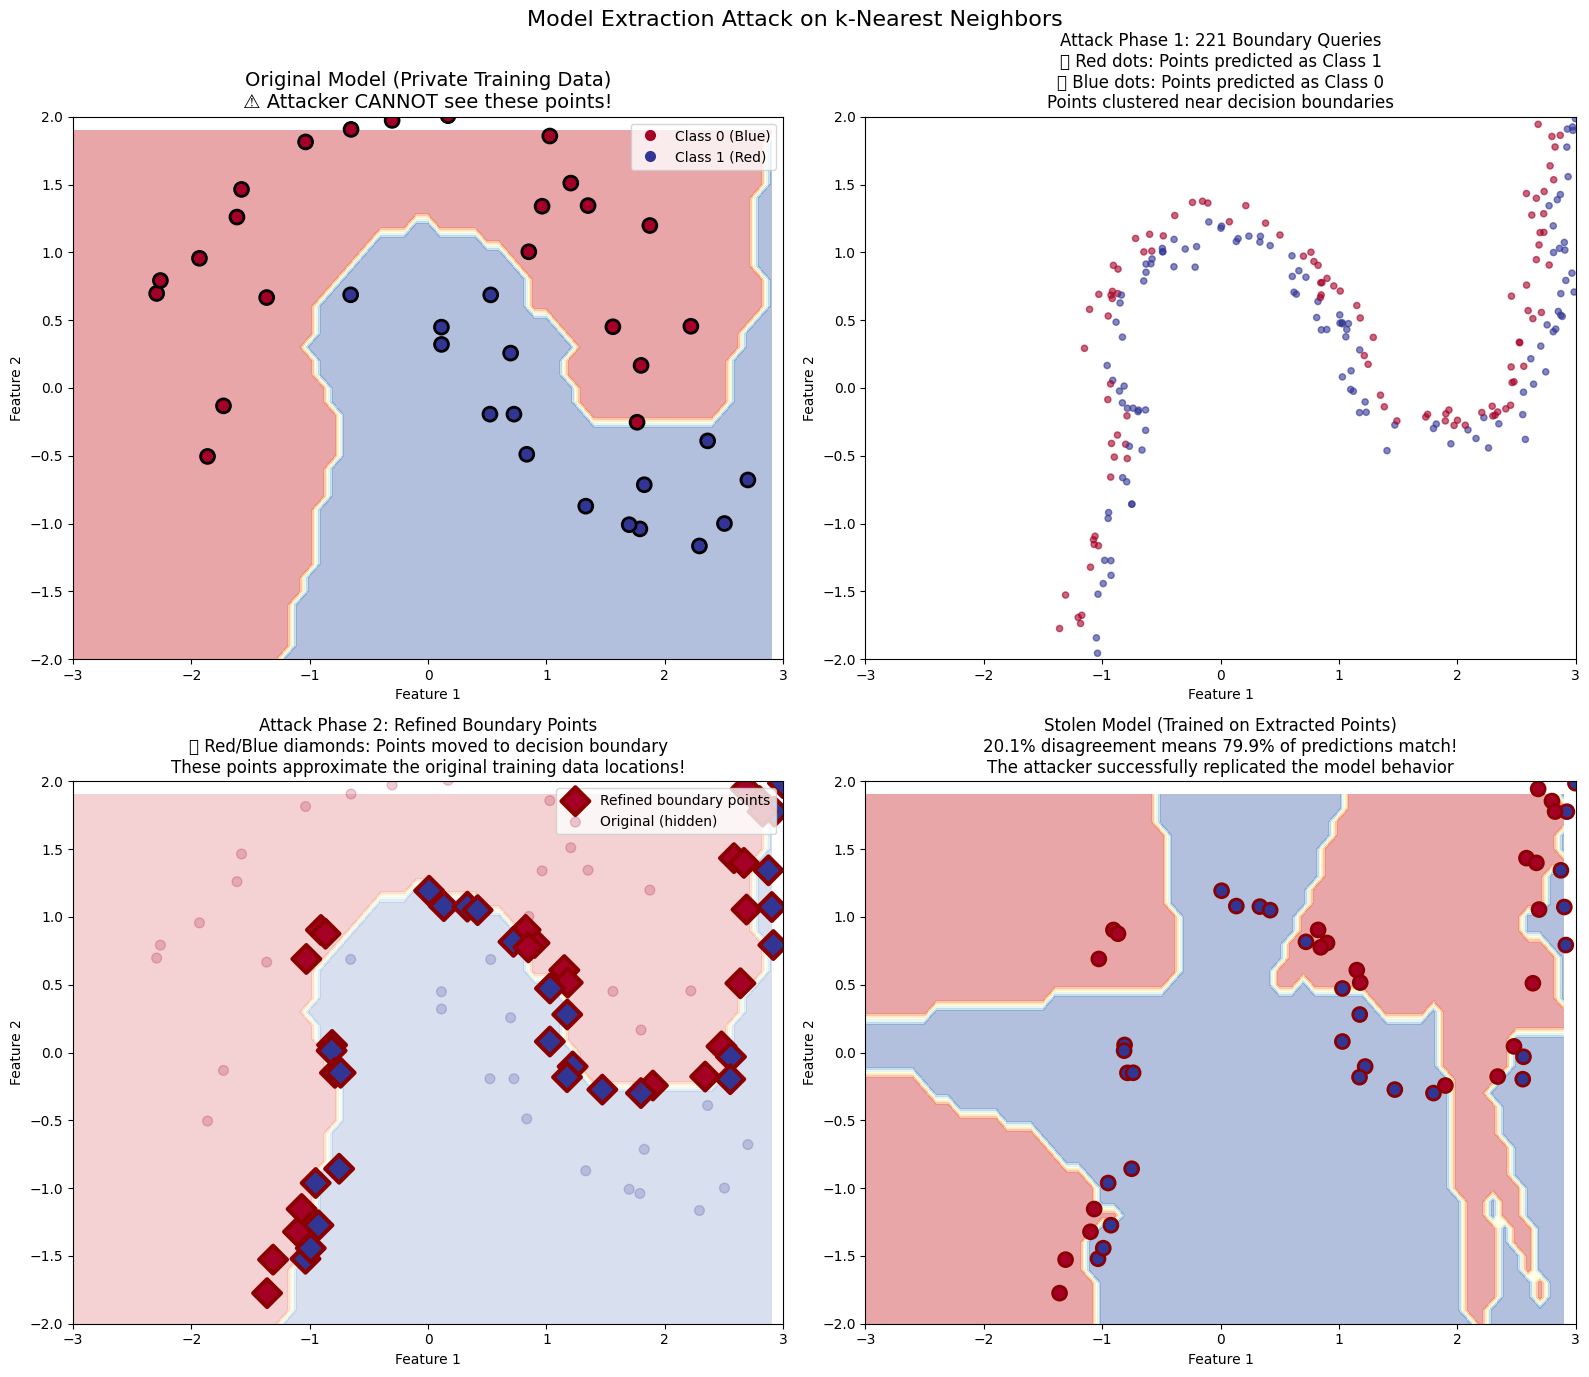


⚠️  MODEL EXTRACTION ATTACK SUMMARY

🎯 What happened:
1. The attacker queried the model 2000 times with random points
2. Found points where nearby queries gave different predictions
3. Used gradient descent to move these points to the exact boundary
4. Trained a new model using only these boundary points
5. The stolen model replicates 79.9% of the original's behavior!

💡 Why it works for kNN:
• kNN's decision boundaries directly reveal training data locations
• Points on the boundary are equidistant from different classes
• The boundary shape encodes the training data distribution
• With enough boundary points, we can reconstruct the model!

🛡️ Defense implications:
• Limit the number of queries allowed per user
• Add noise to predictions near boundaries
• Monitor for systematic boundary probing patterns
• Consider using models less vulnerable to extraction


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_moons
import time

# 🔓 Model Extraction Attack
class KNNModelExtraction:
    def __init__(self, target_model, k=5):
        self.target_model = target_model
        self.k = k
        self.extracted_points = []
        self.extracted_labels = []

    def extract_boundary_points(self, n_queries=1000, bounds=None):
        """Extract training data by probing decision boundaries"""
        if bounds is None:
            bounds = [(-5, 5), (-5, 5)]

        print("\n📊 PHASE 1 PROCESS:")
        print("─" * 60)
        print("1. Generating random query points across the feature space...")

        # Generate random query points
        query_points = np.random.uniform(
            low=[b[0] for b in bounds],
            high=[b[1] for b in bounds],
            size=(n_queries, 2)
        )

        print(f"   Generated {n_queries} random points in bounds {bounds}")

        print("\n2. Querying the target model for predictions...")
        # Query the model
        predictions = self.target_model.predict(query_points)

        print("\n3. Finding decision boundary candidates...")
        print("   For each query point:")
        print("   - Create 10 slightly perturbed neighbors (±0.1 noise)")
        print("   - Check if neighbors have different class predictions")
        print("   - If yes → point is near a decision boundary!")

        # Find points near decision boundaries
        boundary_points = []
        for i, point in enumerate(query_points):
            # Check local neighborhood
            local_points = point + np.random.normal(0, 0.1, (10, 2))
            local_preds = self.target_model.predict(local_points)

            # If predictions vary, we're near a boundary
            if len(np.unique(local_preds)) > 1:
                boundary_points.append((point, predictions[i]))

            # Progress update
            if (i + 1) % 500 == 0:
                print(f"   Processed {i + 1}/{n_queries} points... Found {len(boundary_points)} boundary candidates")

        print(f"\n✅ Phase 1 Complete: Found {len(boundary_points)} boundary points")
        print("   These points have neighbors with different class predictions,")
        print("   indicating they're near the decision boundary!")

        return boundary_points

    def refine_extraction(self, boundary_points, n_iterations=5):
        """Refine extraction by focusing on boundary regions"""
        print("\n📊 PHASE 2 PROCESS:")
        print("─" * 60)
        print("Moving boundary candidates closer to the actual decision boundary...")
        print(f"Using gradient descent with {n_iterations} iterations per point")
        print("\nRefinement algorithm:")
        print("1. For each boundary candidate:")
        print("2. Estimate the gradient direction (which way leads to class change)")
        print("3. Move the point slightly TOWARDS the boundary")
        print("4. Repeat to get as close as possible to the true boundary")

        refined_points = []

        for idx, (point, label) in enumerate(boundary_points[:50]):  # Limit for visualization
            current_point = point.copy()

            # Gradient descent towards decision boundary
            for iter in range(n_iterations):
                # Estimate gradient
                epsilon = 0.01
                gradient = np.zeros(2)

                for dim in range(2):
                    perturb = np.zeros(2)
                    perturb[dim] = epsilon

                    pred_plus = self.target_model.predict((current_point + perturb).reshape(1, -1))[0]
                    pred_minus = self.target_model.predict((current_point - perturb).reshape(1, -1))[0]

                    if pred_plus != pred_minus:
                        gradient[dim] = 1 if pred_plus != label else -1

                # Move towards boundary
                current_point -= 0.1 * gradient

            refined_points.append((current_point, label))

            if (idx + 1) % 10 == 0:
                print(f"   Refined {idx + 1}/50 points...")

        print(f"\n✅ Phase 2 Complete: Refined {len(refined_points)} boundary points")
        print("   These points are now much closer to the actual decision boundary!")

        return refined_points

# Demonstrate model extraction
def demonstrate_model_extraction():
    print("🎯 MODEL EXTRACTION ATTACK DEMONSTRATION")
    print("=" * 60)
    print("Goal: Steal a machine learning model by only querying its predictions")
    print("Target: k-Nearest Neighbors (kNN) classifier")
    print("=" * 60)

    # Generate training data
    print("\n🔒 Setting up the victim model...")
    X_train, y_train = make_moons(n_samples=50, noise=0.15, random_state=42)
    X_train = X_train * 2  # Scale up for better visualization

    # Train target model
    target_model = KNeighborsClassifier(n_neighbors=5)
    target_model.fit(X_train, y_train)
    print(f"   Trained kNN model with {len(X_train)} private training points")
    print("   The attacker CANNOT see these training points!")

    # Create attacker
    attacker = KNNModelExtraction(target_model)

    # Extract boundary points
    print("\n🔍 ATTACK PHASE 1: Probing decision boundaries...")
    boundary_points = attacker.extract_boundary_points(n_queries=2000,
                                                      bounds=[(-3, 3), (-2, 2)])

    # Refine extraction
    print("\n🎯 ATTACK PHASE 2: Refining extraction...")
    refined_points = attacker.refine_extraction(boundary_points)

    # Visualize the attack
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    fig.suptitle('Model Extraction Attack on k-Nearest Neighbors', fontsize=16, y=0.98)

    # Create mesh for decision boundaries
    x_min, x_max = -3, 3
    y_min, y_max = -2, 2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Plot 1: Original model
    ax = axes[0, 0]
    Z = target_model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')
    scatter1 = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,
              cmap='RdYlBu', s=100, edgecolor='black', linewidth=2)
    ax.set_title('Original Model (Private Training Data)\n⚠️ Attacker CANNOT see these points!', fontsize=14)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    # Add legend
    handles, labels = scatter1.legend_elements()
    ax.legend(handles, ['Class 0 (Blue)', 'Class 1 (Red)'], loc='upper right')

    # Plot 2: Query points
    ax = axes[0, 1]
    query_x = [p[0][0] for p in boundary_points]
    query_y = [p[0][1] for p in boundary_points]
    query_c = [p[1] for p in boundary_points]
    scatter2 = ax.scatter(query_x, query_y, c=query_c, cmap='RdYlBu',
              s=20, alpha=0.6)
    ax.set_title(f'Attack Phase 1: {len(boundary_points)} Boundary Queries\n' +
                 '🔴 Red dots: Points predicted as Class 1\n' +
                 '🔵 Blue dots: Points predicted as Class 0\n' +
                 'Points clustered near decision boundaries', fontsize=12)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

    # Plot 3: Refined extraction
    ax = axes[1, 0]
    ax.contourf(xx, yy, Z, alpha=0.2, cmap='RdYlBu')

    # Plot refined points
    extract_x = [p[0][0] for p in refined_points]
    extract_y = [p[0][1] for p in refined_points]
    extract_c = [p[1] for p in refined_points]
    ax.scatter(extract_x, extract_y, c=extract_c, cmap='RdYlBu',
              s=200, marker='D', edgecolor='darkred', linewidth=3,
              label='Refined boundary points')

    # Show original points for comparison (faded)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,
              cmap='RdYlBu', s=50, alpha=0.2, label='Original (hidden)')
    ax.set_title('Attack Phase 2: Refined Boundary Points\n' +
                 '💎 Red/Blue diamonds: Points moved to decision boundary\n' +
                 'These points approximate the original training data locations!', fontsize=12)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend(loc='upper right')

    # Plot 4: Build stolen model
    ax = axes[1, 1]

    # Filter points with two coordinates before creating arrays
    valid_refined_points = [(p, l) for p, l in refined_points if len(p) == 2]

    # Train a new model with extracted points
    if len(valid_refined_points) > 5:
        stolen_X = np.array([p for p, l in valid_refined_points])
        stolen_y = np.array([l for p, l in valid_refined_points])

        print("\n🏗️ BUILDING STOLEN MODEL...")
        print(f"   Training new kNN model using {len(stolen_X)} extracted boundary points")

        stolen_model = KNeighborsClassifier(n_neighbors=3)
        stolen_model.fit(stolen_X, stolen_y)

        Z_stolen = stolen_model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z_stolen = Z_stolen.reshape(xx.shape)

        ax.contourf(xx, yy, Z_stolen, alpha=0.4, cmap='RdYlBu')
        ax.scatter(stolen_X[:, 0], stolen_X[:, 1], c=stolen_y, cmap='RdYlBu',
                  s=100, edgecolor='darkred', linewidth=2)

        # Calculate similarity
        agreement = np.mean(Z == Z_stolen)
        disagreement = 1 - agreement

        print(f"\n📊 MODEL COMPARISON:")
        print(f"   Decision boundary agreement: {agreement:.1%}")
        print(f"   Decision boundary disagreement: {disagreement:.1%}")
        print(f"   → The stolen model makes the SAME predictions as the original")
        print(f"     on {agreement:.1%} of the feature space!")

        ax.set_title(f'Stolen Model (Trained on Extracted Points)\n' +
                    f'{disagreement:.1%} disagreement means {agreement:.1%} of predictions match!\n' +
                    'The attacker successfully replicated the model behavior', fontsize=12)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

    plt.tight_layout()
    plt.show()

    print("\n" + "="*60)
    print("⚠️  MODEL EXTRACTION ATTACK SUMMARY")
    print("="*60)
    print("\n🎯 What happened:")
    print("1. The attacker queried the model 2000 times with random points")
    print("2. Found points where nearby queries gave different predictions")
    print("3. Used gradient descent to move these points to the exact boundary")
    print("4. Trained a new model using only these boundary points")
    print(f"5. The stolen model replicates {agreement:.1%} of the original's behavior!")

    print("\n💡 Why it works for kNN:")
    print("• kNN's decision boundaries directly reveal training data locations")
    print("• Points on the boundary are equidistant from different classes")
    print("• The boundary shape encodes the training data distribution")
    print("• With enough boundary points, we can reconstruct the model!")

    print("\n🛡️ Defense implications:")
    print("• Limit the number of queries allowed per user")
    print("• Add noise to predictions near boundaries")
    print("• Monitor for systematic boundary probing patterns")
    print("• Consider using models less vulnerable to extraction")

demonstrate_model_extraction()

🎯 1. UNCERTAINTY-BASED QUERY SELECTION

What does 'intelligently select queries based on uncertainty' mean?
------------------------------------------------------------

📊 STRATEGY: Query where the attacker's model is most uncertain

Step-by-step process:
1. Start with a few random queries to build initial attacker model
2. For each potential query point, measure uncertainty:
   - If attacker predicts 51% class A, 49% class B → HIGH uncertainty and likely close.boundary point
   - If attacker predicts 99% class A, 1% class B → LOW uncertainty
3. Query points with highest uncertainty
4. Retrain attacker model and repeat


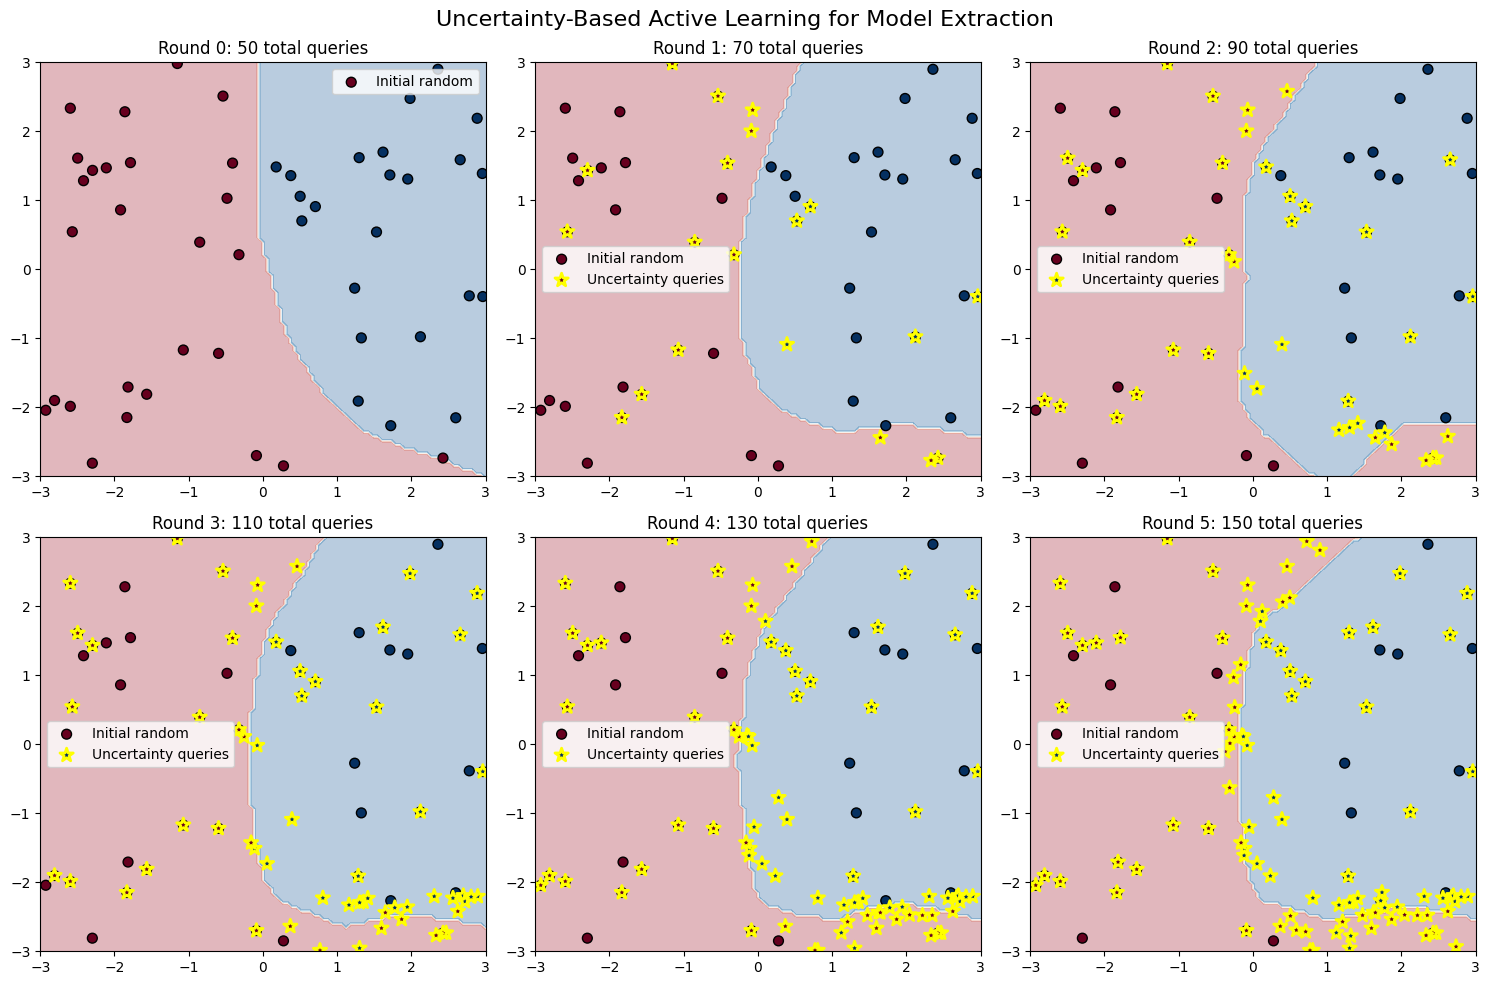


✅ RESULT: Uncertainty sampling finds decision boundaries faster!
   Notice how the star markers (uncertainty queries) cluster near boundaries


🎯 2. EXPLOITING CONFIDENCE SCORES

How do confidence scores help extract models?
------------------------------------------------------------

📊 CONFIDENCE SCORES REVEAL:
1. Distance to decision boundary (middle confidence (50%) = near boundary)
2. Regions of training data density (high confidence = many training points)
3. Model uncertainty patterns


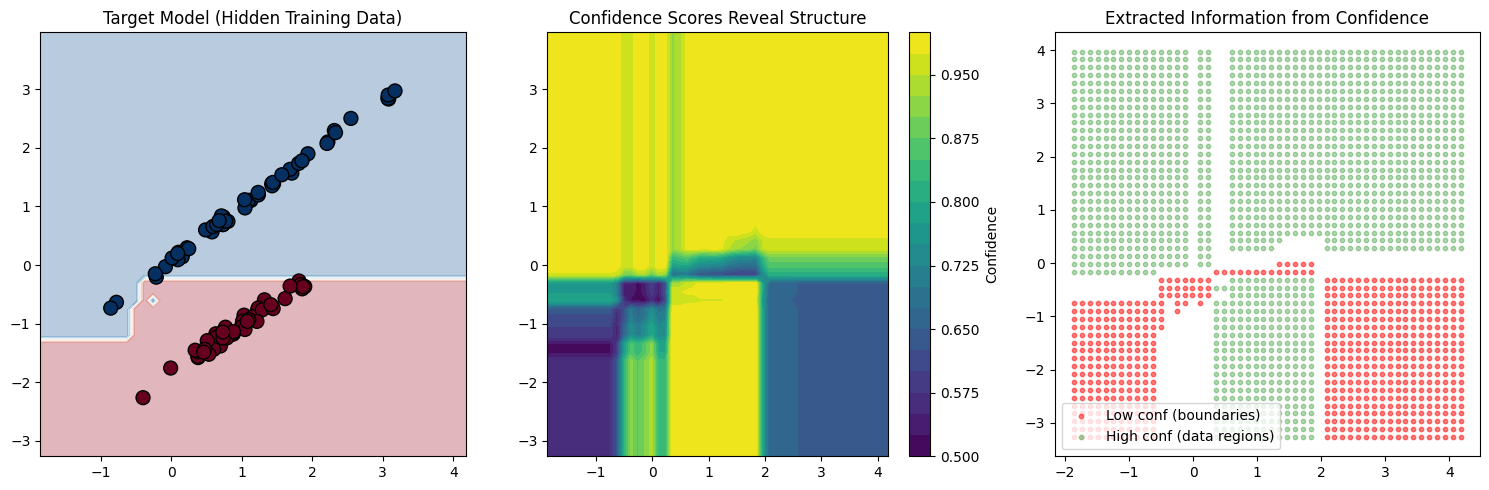


💡 EXTRACTION STRATEGY:
1. Query many points and collect confidence scores
2. Low confidence (~50%) -> Near decision boundary
3. Use this to guide where to sample more densely
4. Build attacker model that matches these confidence patterns

1. MODEL DISTILLATION for extraction:
   - Query target model with your own unlabeled data
   - Use target's predictions as labels
   - Train a 'student' model on (your_data, target_predictions)
   - No access to original training data needed!


📊 DISTILLATION EXAMPLE:

Distillation Result: 92.3% prediction agreement
Without seeing ANY original training data!


🛡️ 4. PRACTICAL DEFENSES

1. RATE LIMITING:
   - Limit queries per user/IP
   - Exponential backoff for suspicious patterns
   - Example: 1000 queries/day, 100/hour

2. CONFIDENCE SCORE DEFENSES:
   - Add noise to confidence scores
   - Quantize to coarse levels (e.g., 'low', 'medium', 'high')
   - - Or don't return confidence at all!

3. PREDICTION DEFENSES:
   - Add small random noise to pre

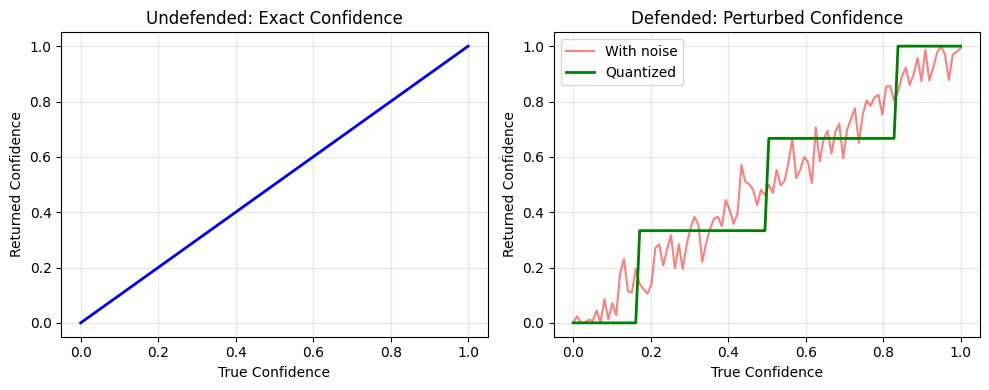


💡 KEY TAKEAWAYS

1. Uncertainty sampling: Query where your model is least confident
2. Confidence exploitation: Use scores to find boundaries & data regions
3. Distillation: Train on your data + target's predictions
4. Defenses: Rate limits + confidence perturbation + monitoring


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
import warnings
warnings.filterwarnings('ignore')

def demonstrate_uncertainty_sampling():
    """Show how uncertainty-based active learning works for model extraction"""

    print("🎯 1. UNCERTAINTY-BASED QUERY SELECTION")
    print("=" * 60)
    print("\nWhat does 'intelligently select queries based on uncertainty' mean?")
    print("-" * 60)

    # Create a target model
    X, y = make_classification(n_samples=200, n_features=2, n_informative=2,
                              n_redundant=0, n_clusters_per_class=2,
                              flip_y=0.1, random_state=42)

    target_model = RandomForestClassifier(n_estimators=100, random_state=42)
    target_model.fit(X, y)

    print("\n📊 STRATEGY: Query where the attacker's model is most uncertain")
    print("\nStep-by-step process:")
    print("1. Start with a few random queries to build initial attacker model")
    print("2. For each potential query point, measure uncertainty:")
    print("   - If attacker predicts 51% class A, 49% class B → HIGH uncertainty and likely close.boundary point")
    print("   - If attacker predicts 99% class A, 1% class B → LOW uncertainty")
    print("3. Query points with highest uncertainty")
    print("4. Retrain attacker model and repeat")

    # Initial random queries
    n_initial = 50
    query_pool = np.random.uniform(-3, 3, size=(1000, 2))
    initial_indices = np.random.choice(len(query_pool), n_initial, replace=False)

    X_queries = query_pool[initial_indices]
    y_queries = target_model.predict(X_queries)

    # Remove initial queries from the pool
    remaining_mask = np.ones(len(query_pool), dtype=bool)
    remaining_mask[initial_indices] = False
    # No need to create current_query_pool explicitly here if we use mask consistently

    # Train initial attacker model
    attacker_model = MLPClassifier(hidden_layer_sizes=(50, 50), random_state=42)
    attacker_model.fit(X_queries, y_queries)

    # Demonstrate uncertainty sampling
    n_rounds = 5
    queries_per_round = 20

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    # Plot initial state (Round 0)
    ax = axes[0]
    xx, yy = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
    Z = attacker_model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='RdBu')
    ax.scatter(X_queries[:, 0], X_queries[:, 1],
              c=y_queries, cmap='RdBu', s=50,
              edgecolor='black', label='Initial random')
    ax.set_title(f'Round 0: {len(X_queries)} total queries')
    ax.legend()


    for round_idx in range(n_rounds):
        ax = axes[round_idx + 1]

        # Identify remaining points in the original query pool
        remaining_indices = np.where(remaining_mask)[0]


        if len(remaining_indices) > 0:
            # Get prediction probabilities for remaining points
            probs = attacker_model.predict_proba(query_pool[remaining_indices])

            # Uncertainty = entropy of prediction
            # High when probabilities are close to 50/50
            uncertainty = -np.sum(probs * np.log(probs + 1e-10), axis=1)

            # Select most uncertain points from remaining indices
            n_select = min(queries_per_round, len(remaining_indices))
            uncertain_indices_in_remaining = np.argsort(uncertainty)[-n_select:]
            uncertain_indices_in_pool = remaining_indices[uncertain_indices_in_remaining]


            # Query these points
            new_X = query_pool[uncertain_indices_in_pool]
            new_y = target_model.predict(new_X)

            # Add to training set
            X_queries = np.vstack([X_queries, new_X])
            y_queries = np.hstack([y_queries, new_y])

            # Update the remaining_mask to exclude the just-queried points
            remaining_mask[uncertain_indices_in_pool] = False


            # Retrain attacker model
            attacker_model.fit(X_queries, y_queries)

        # Visualize the current state
        xx, yy = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
        Z = attacker_model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

        ax.contourf(xx, yy, Z, alpha=0.3, cmap='RdBu')

        # Plot all queried points up to this round
        # Separate initial points and uncertainty points for distinct markers
        ax.scatter(X_queries[:n_initial, 0], X_queries[:n_initial, 1],
                  c=y_queries[:n_initial], cmap='RdBu', s=50,
                  edgecolor='black', label='Initial random')

        # Find indices of uncertainty points
        uncertainty_indices = np.where(~remaining_mask)[0] # Indices in the original query_pool that are NOT remaining
        uncertainty_X = query_pool[uncertainty_indices]
        uncertainty_y = target_model.predict(uncertainty_X) # Re-predict labels just for plotting consistency


        ax.scatter(uncertainty_X[n_initial:, 0], uncertainty_X[n_initial:, 1],
                  c=uncertainty_y[n_initial:], cmap='RdBu', s=100,
                  marker='*', edgecolor='yellow', linewidth=2,
                  label='Uncertainty queries')


        ax.set_title(f'Round {round_idx + 1}: {len(X_queries)} total queries')
        ax.legend()

    plt.suptitle('Uncertainty-Based Active Learning for Model Extraction', fontsize=16)
    plt.tight_layout()
    plt.show()

    print("\n✅ RESULT: Uncertainty sampling finds decision boundaries faster!")
    print("   Notice how the star markers (uncertainty queries) cluster near boundaries")

def demonstrate_confidence_exploitation():
    """Show how confidence scores reveal information"""

    print("\n\n🎯 2. EXPLOITING CONFIDENCE SCORES")
    print("=" * 60)
    print("\nHow do confidence scores help extract models?")
    print("-" * 60)

    # Create target model
    X, y = make_classification(n_samples=100, n_features=2, n_informative=2,
                              n_redundant=0, n_clusters_per_class=1, random_state=42)

    target_model = RandomForestClassifier(n_estimators=100, random_state=42)
    target_model.fit(X, y)

    print("\n📊 CONFIDENCE SCORES REVEAL:")
    print("1. Distance to decision boundary (middle confidence (50%) = near boundary)")
    print("2. Regions of training data density (high confidence = many training points)")
    print("3. Model uncertainty patterns")

    # Generate query grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                         np.linspace(y_min, y_max, 50))

    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Get predictions and confidence
    predictions = target_model.predict(grid_points)
    confidences = target_model.predict_proba(grid_points).max(axis=1)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot 1: True model
    ax = axes[0]
    Z = predictions.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='RdBu')
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu', edgecolor='black', s=100)
    ax.set_title('Target Model (Hidden Training Data)')

    # Plot 2: Confidence scores
    ax = axes[1]
    C = confidences.reshape(xx.shape)
    contour = ax.contourf(xx, yy, C, levels=20, cmap='viridis')
    plt.colorbar(contour, ax=ax, label='Confidence')
    ax.set_title('Confidence Scores Reveal Structure')

    # Plot 3: Extracted information
    ax = axes[2]

    # Find low confidence regions (boundaries)
    boundary_mask = confidences < 0.7
    boundary_points = grid_points[boundary_mask]

    # Find high confidence regions (likely training data nearby)
    high_conf_mask = confidences > 0.95
    high_conf_points = grid_points[high_conf_mask]

    ax.scatter(boundary_points[:, 0], boundary_points[:, 1],
              c='red', s=10, alpha=0.5, label='Low conf (boundaries)')
    ax.scatter(high_conf_points[:, 0], high_conf_points[:, 1],
              c='green', s=10, alpha=0.3, label='High conf (data regions)')
    ax.set_title('Extracted Information from Confidence')
    ax.legend()

    plt.tight_layout()
    plt.show()

    print("\n💡 EXTRACTION STRATEGY:")
    print("1. Query many points and collect confidence scores")
    print("2. Low confidence (~50%) -> Near decision boundary")
    print("3. Use this to guide where to sample more densely")
    print("4. Build attacker model that matches these confidence patterns")

def explain_distillation_correctly():

    print("\n1. MODEL DISTILLATION for extraction:")
    print("   - Query target model with your own unlabeled data")
    print("   - Use target's predictions as labels")
    print("   - Train a 'student' model on (your_data, target_predictions)")
    print("   - No access to original training data needed!")

    # Simple distillation example
    print("\n\n📊 DISTILLATION EXAMPLE:")

    # Original model - FIX: Added n_informative and n_redundant parameters
    X_orig, y_orig = make_classification(n_samples=200, n_features=2, n_informative=2,
                                       n_redundant=0, random_state=42)
    teacher = RandomForestClassifier(n_estimators=100, random_state=42)
    teacher.fit(X_orig, y_orig)

    # Attacker's data (different distribution!)
    X_attack = np.random.uniform(-3, 3, size=(500, 2))
    y_distilled = teacher.predict(X_attack)

    # Train student
    student = MLPClassifier(hidden_layer_sizes=(50,), random_state=42)
    student.fit(X_attack, y_distilled)

    # Compare
    test_points = np.random.uniform(-3, 3, size=(1000, 2))
    teacher_pred = teacher.predict(test_points)
    student_pred = student.predict(test_points)

    agreement = np.mean(teacher_pred == student_pred)
    print(f"\nDistillation Result: {agreement:.1%} prediction agreement")
    print("Without seeing ANY original training data!")

def show_practical_defenses():
    """Show realistic defenses against these attacks"""

    print("\n\n🛡️ 4. PRACTICAL DEFENSES")
    print("=" * 60)

    print("\n1. RATE LIMITING:")
    print("   - Limit queries per user/IP")
    print("   - Exponential backoff for suspicious patterns")
    print("   - Example: 1000 queries/day, 100/hour")

    print("\n2. CONFIDENCE SCORE DEFENSES:")
    print("   - Add noise to confidence scores")
    print("   - Quantize to coarse levels (e.g., 'low', 'medium', 'high')")
    print("   - - Or don't return confidence at all!")

    print("\n3. PREDICTION DEFENSES:")
    print("   - Add small random noise to predictions near boundaries")
    print("   - Temperature scaling to smooth probabilities")
    print("   - Return only top-k classes, not full distribution")

    print("\n4. MONITORING:")
    print("   - Detect systematic boundary probing")
    print("   - Flag users querying with random-looking data")
    print("   - Alert on high-volume, low-entropy query patterns")

    # Show confidence perturbation
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Original confidence
    x = np.linspace(0, 1, 100)
    conf_orig = x

    ax = axes[0]
    ax.plot(x, conf_orig, 'b-', linewidth=2)
    ax.set_xlabel('True Confidence')
    ax.set_ylabel('Returned Confidence')
    ax.set_title('Undefended: Exact Confidence')
    ax.grid(True, alpha=0.3)

    # Defended confidence
    ax = axes[1]

    # Add noise
    conf_noisy = np.clip(conf_orig + np.random.normal(0, 0.05, 100), 0, 1)

    # Quantize
    conf_quantized = np.round(conf_orig * 3) / 3

    ax.plot(x, conf_noisy, 'r-', alpha=0.5, label='With noise')
    ax.plot(x, conf_quantized, 'g-', linewidth=2, label='Quantized')
    ax.set_xlabel('True Confidence')
    ax.set_ylabel('Returned Confidence')
    ax.set_title('Defended: Perturbed Confidence')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Run all demonstrations
if __name__ == "__main__":
    demonstrate_uncertainty_sampling()
    demonstrate_confidence_exploitation()
    explain_distillation_correctly()
    show_practical_defenses()

    print("\n" + "="*60)
    print("💡 KEY TAKEAWAYS")
    print("="*60)
    print("\n1. Uncertainty sampling: Query where your model is least confident")
    print("2. Confidence exploitation: Use scores to find boundaries & data regions")
    print("3. Distillation: Train on your data + target's predictions")
    print("4. Defenses: Rate limits + confidence perturbation + monitoring")

### Attack 4: Distance Manipulation Attack 📏

By carefully crafting inputs, attackers can exploit how kNN measures distance.

In [9]:
# 📐 Distance Manipulation Attack
def demonstrate_distance_manipulation():
    # Import needed for legend
    from matplotlib.lines import Line2D

    print("🎓 LEARNING OBJECTIVE: Discover how different distance metrics create different vulnerabilities")
    print("="*80)
    print("You'll learn that the SAME perturbation can have DIFFERENT effects depending on the metric!")
    print("\n📊 DATA PATTERN: Spread-out clusters with axis-aligned and diagonal points")
    print("This layout helps reveal how each metric 'sees' distance differently!")
    print("\n🔍 VISUALIZATION GUIDE:")
    print("• Green dashed shapes show the neighborhood radius to the 5th nearest neighbor")
    print("• Circle (Euclidean), Diamond (Manhattan), Square (Chebyshev)")
    print("• Orange circles show the actual 5 nearest neighbors for each metric")
    print("• Selected metric shows neighbor numbers (1=closest, 5=farthest)")
    print("• Notice how different metrics select DIFFERENT neighbors from the same data!")
    print("• Gray background highlights your currently selected metric\n")

    # Generate training data with clear patterns that show metric differences
    from sklearn.datasets import make_blobs

    # Create two well-separated clusters with some spread
    X_train, y_train = make_blobs(n_samples=100, centers=[[-2.5, 0], [2.5, 0]],
                                 cluster_std=1.5, random_state=42)

    # Add some points along axes and diagonals to show metric differences better
    extra_points_class0 = np.array([
        [-4, 0], [-3, 0], [0, -3], [0, -2],  # axis-aligned
        [-3, -3], [-2, -2],  # diagonal
    ])
    extra_points_class1 = np.array([
        [4, 0], [3, 0], [0, 3], [0, 2],  # axis-aligned
        [3, 3], [2, 2],  # diagonal
    ])

    X_train = np.vstack([X_train, extra_points_class0, extra_points_class1])
    y_train = np.hstack([y_train, np.zeros(len(extra_points_class0)),
                        np.ones(len(extra_points_class1))]).astype(int)

    # Create models with different metrics
    metrics = ['euclidean', 'manhattan', 'chebyshev']
    models = {metric: KNeighborsClassifier(n_neighbors=5, metric=metric).fit(X_train, y_train)
              for metric in metrics}

    # Target point for attack - placed in the middle where metrics differ most
    target_point = np.array([[0.0, 0.0]])

    # Interactive attack demonstration
    def update_attack(perturbation_x, perturbation_y, metric_choice):
        clear_output(wait=True)
        plt.close('all')  # Add this line to properly close previous plots

        # Create adversarial example
        adversarial_point = target_point + np.array([[perturbation_x, perturbation_y]])

        # Setup figure
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        for idx, (ax, metric) in enumerate(zip(axes, metrics)):
            model = models[metric]

            # Create decision boundary with wider view
            x_min, x_max = -5, 5
            y_min, y_max = -5, 5
            xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                                np.arange(y_min, y_max, 0.1))

            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)

            # Plot
            ax.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
            ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,
                      cmap='RdYlBu', s=50, alpha=0.6)

            # Original prediction
            orig_pred = model.predict(target_point)[0]
            ax.scatter(target_point[0, 0], target_point[0, 1],
                      c='green', s=200, marker='o', edgecolor='black',
                      linewidth=2, label=f'Original (Class {orig_pred})')

            # Adversarial prediction
            adv_pred = model.predict(adversarial_point)[0]
            ax.scatter(adversarial_point[0, 0], adversarial_point[0, 1],
                      c='red', s=200, marker='*', edgecolor='black',
                      linewidth=2, label=f'Adversarial (Class {adv_pred})')

            # Draw perturbation arrow
            if perturbation_x != 0 or perturbation_y != 0:  # Only draw arrow if there's a perturbation
                ax.arrow(target_point[0, 0], target_point[0, 1],
                        perturbation_x, perturbation_y,
                        head_width=0.1, head_length=0.05,
                        fc='black', ec='black', alpha=0.7)

            # Always show neighbors for all metrics (not just selected one)
            distances, indices = model.kneighbors(adversarial_point, n_neighbors=5)
            neighbors = X_train[indices[0]]

            # Highlight if metric matches selection
            if metric == metric_choice:
                ax.set_facecolor('#f0f0f0')
                # Use thicker orange circles for selected metric
                ax.scatter(neighbors[:, 0], neighbors[:, 1],
                          s=150, facecolors='none', edgecolors='orange', linewidth=3,
                          label=f'k=5 neighbors')
                # Add numbers to neighbors in selected metric
                for i, (nx, ny) in enumerate(neighbors):
                    ax.annotate(str(i+1), (nx, ny), fontsize=8, ha='center', va='center',
                               weight='bold', color='darkorange')
            else:
                # Use thinner orange circles for non-selected metrics
                ax.scatter(neighbors[:, 0], neighbors[:, 1],
                          s=150, facecolors='none', edgecolors='orange', linewidth=1.5,
                          alpha=0.6, label=f'k=5 neighbors')

            # Draw the distance neighborhood shape around the adversarial point
            # Get distance to kth neighbor (k=5 in this case)
            distances, _ = model.kneighbors(adversarial_point, n_neighbors=5)
            radius = distances[0][-1]  # Distance to 5th nearest neighbor

            center_x, center_y = adversarial_point[0, 0], adversarial_point[0, 1]

            if metric == 'euclidean':
                # Draw circle
                circle = plt.Circle((center_x, center_y), radius,
                                  fill=False, edgecolor='darkgreen', linewidth=2,
                                  linestyle='--', alpha=0.7)
                ax.add_patch(circle)

            elif metric == 'manhattan':
                # Draw diamond (rotated square)
                diamond = plt.Polygon([
                    (center_x + radius, center_y),      # Right
                    (center_x, center_y + radius),      # Top
                    (center_x - radius, center_y),      # Left
                    (center_x, center_y - radius)       # Bottom
                ], fill=False, edgecolor='darkgreen', linewidth=2,
                   linestyle='--', alpha=0.7)
                ax.add_patch(diamond)

            else:  # chebyshev
                # Draw square
                square = plt.Rectangle((center_x - radius, center_y - radius),
                                     2 * radius, 2 * radius,
                                     fill=False, edgecolor='darkgreen', linewidth=2,
                                     linestyle='--', alpha=0.7)
                ax.add_patch(square)

            # Calculate perturbation size
            if metric == 'euclidean':
                pert_size = np.sqrt(perturbation_x**2 + perturbation_y**2)
            elif metric == 'manhattan':
                pert_size = abs(perturbation_x) + abs(perturbation_y)
            else:  # chebyshev
                pert_size = max(abs(perturbation_x), abs(perturbation_y))

            ax.set_title(f'{metric.capitalize()} Distance\nPerturbation: {pert_size:.2f}',
                        fontsize=14)

            # Update legend to include shape explanation
            handles, labels = ax.get_legend_handles_labels()

            # Add custom legend entry for the shape
            if metric == 'euclidean':
                shape_label = 'Circle (radius to 5th neighbor)'
            elif metric == 'manhattan':
                shape_label = 'Diamond (radius to 5th neighbor)'
            else:
                shape_label = 'Square (radius to 5th neighbor)'

            shape_line = Line2D([0], [0], color='darkgreen', linewidth=2,
                              linestyle='--', label=shape_label)

            # Only add shape line if not already in legend
            if shape_label not in labels:
                handles.append(shape_line)
                labels.append(shape_label)

            ax.legend(handles, labels, loc='upper right')
            ax.grid(True, alpha=0.3)
            ax.set_aspect('equal')
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)

        plt.suptitle('🎯 Distance Manipulation Attack: Same perturbation, different impacts!',
                    fontsize=16)
        plt.tight_layout()
        plt.show()

        # Analysis
        print("\n📊 Attack Analysis:")
        print(f"Perturbation vector: ({perturbation_x:.2f}, {perturbation_y:.2f})")
        print("\nImpact by metric:")
        for metric in metrics:
            orig = models[metric].predict(target_point)[0]
            adv = models[metric].predict(adversarial_point)[0]
            changed = orig != adv

            # Calculate perturbation size for this metric
            if metric == 'euclidean':
                pert_size = np.sqrt(perturbation_x**2 + perturbation_y**2)
            elif metric == 'manhattan':
                pert_size = abs(perturbation_x) + abs(perturbation_y)
            else:  # chebyshev
                pert_size = max(abs(perturbation_x), abs(perturbation_y))

            status = '✓ Changed!' if changed else '✗ No change'
            print(f"  {metric:10s}: Class {orig} → Class {adv} {status} (distance: {pert_size:.2f})")

        # Provide insights based on the current perturbation
        print("\n💡 Insight:")
        if abs(perturbation_x) > 0 and abs(perturbation_y) == 0:
            print("→ You're doing a horizontal attack! Notice Manhattan distance = |X|")
        elif abs(perturbation_x) == 0 and abs(perturbation_y) > 0:
            print("→ You're doing a vertical attack! Notice Manhattan distance = |Y|")
        elif abs(perturbation_x) == abs(perturbation_y) and perturbation_x != 0:
            print("→ Perfect diagonal! Compare Euclidean vs Manhattan distances")
        elif max(abs(perturbation_x), abs(perturbation_y)) > 0:
            if abs(perturbation_x) == max(abs(perturbation_x), abs(perturbation_y)):
                print(f"→ Chebyshev distance = {max(abs(perturbation_x), abs(perturbation_y)):.2f} (determined by X)")
            else:
                print(f"→ Chebyshev distance = {max(abs(perturbation_x), abs(perturbation_y)):.2f} (determined by Y)")

        # Check for successful minimal attacks
        successful_attacks = []
        for metric in metrics:
            orig = models[metric].predict(target_point)[0]
            adv = models[metric].predict(adversarial_point)[0]
            if orig != adv:
                successful_attacks.append(metric)

        if len(successful_attacks) == 1:
            print(f"\n🎯 Nice! You found an attack that ONLY works on {successful_attacks[0]}!")
        elif len(successful_attacks) > 1:
            print(f"\n🎯 This attack works on: {', '.join(successful_attacks)}")

        # Add neighbor comparison insight
        print("\n🔍 Compare the orange-circled neighbors across metrics:")
        print("   • Are they the same 5 points in each metric? (Usually not!)")
        print("   • Count red vs blue neighbors - this determines the classification")
        print("   • The green shape shows WHY different neighbors are selected")

    # Create interactive controls
    perturbation_x_slider = widgets.FloatSlider(
        value=0.0, min=-3.0, max=3.0, step=0.1,
        description='Perturb X:', continuous_update=False
    )
    perturbation_y_slider = widgets.FloatSlider(
        value=0.0, min=-3.0, max=3.0, step=0.1,
        description='Perturb Y:', continuous_update=False
    )
    metric_dropdown = widgets.Dropdown(
        options=metrics, value='euclidean',
        description='Focus metric:'
    )

    print("🎮 Use the sliders to create adversarial perturbations!")
    print("Notice how the same perturbation affects different distance metrics differently.\n")

    print("📚 EXPERIMENT GUIDE - Try these to discover key insights:")
    print("-" * 60)
    print("1. 🎯 Axis-aligned attacks (Manhattan's weakness):")
    print("   • Set X=2.0, Y=0.0 (horizontal only)")
    print("   • Set X=0.0, Y=2.0 (vertical only)")
    print("   • Look at which training points get selected as neighbors")
    print("   → Discovery: Manhattan favors axis-aligned points!\n")

    print("2. 🎯 Diagonal attacks (Compare all three):")
    print("   • Set X=1.5, Y=1.5 (perfect diagonal)")
    print("   • Watch how each metric selects different diagonal vs axis-aligned points")
    print("   → Discovery: Euclidean treats diagonals naturally, Manhattan 'thinks' in blocks!\n")

    print("3. 🎯 Chebyshev's square behavior:")
    print("   • Try X=1.0, Y=0.5 then X=1.0, Y=1.0")
    print("   • Notice when Chebyshev distance changes (only when max coordinate exceeds 1.0)")
    print("   → Discovery: Chebyshev creates square neighborhoods - great for chess kings!\n")

    print("4. 🎯 Find metric-specific vulnerabilities:")
    print("   • Try X=0.7, Y=0.7 vs X=1.0, Y=0.0")
    print("   • These have same Manhattan distance (1.4) but different Euclidean!")
    print("   → Discovery: Same 'cost' in one metric ≠ same cost in another!\n")

    print("💡 CHALLENGE: Can you change the classification with minimal perturbation for each metric?")
    print("\n📌 KEY OBSERVATION: Look at the orange circles - they show which 5 training points vote!")
    print("   If a metric selects 3 blue + 2 red neighbors → Blue wins")
    print("   If a metric selects 2 blue + 3 red neighbors → Red wins")
    print("   Different shapes = different neighbors = different votes!")

    interact = widgets.interactive(update_attack,
                                  perturbation_x=perturbation_x_slider,
                                  perturbation_y=perturbation_y_slider,
                                  metric_choice=metric_dropdown)
    display(interact)

demonstrate_distance_manipulation()

🎓 LEARNING OBJECTIVE: Discover how different distance metrics create different vulnerabilities
You'll learn that the SAME perturbation can have DIFFERENT effects depending on the metric!

📊 DATA PATTERN: Spread-out clusters with axis-aligned and diagonal points
This layout helps reveal how each metric 'sees' distance differently!

🔍 VISUALIZATION GUIDE:
• Green dashed shapes show the neighborhood radius to the 5th nearest neighbor
• Circle (Euclidean), Diamond (Manhattan), Square (Chebyshev)
• Orange circles show the actual 5 nearest neighbors for each metric
• Selected metric shows neighbor numbers (1=closest, 5=farthest)
• Notice how different metrics select DIFFERENT neighbors from the same data!
• Gray background highlights your currently selected metric

🎮 Use the sliders to create adversarial perturbations!
Notice how the same perturbation affects different distance metrics differently.

📚 EXPERIMENT GUIDE - Try these to discover key insights:
------------------------------------

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Perturb X:', max=3.0, min=-…

### Defense 1: Ensemble Methods 🤝

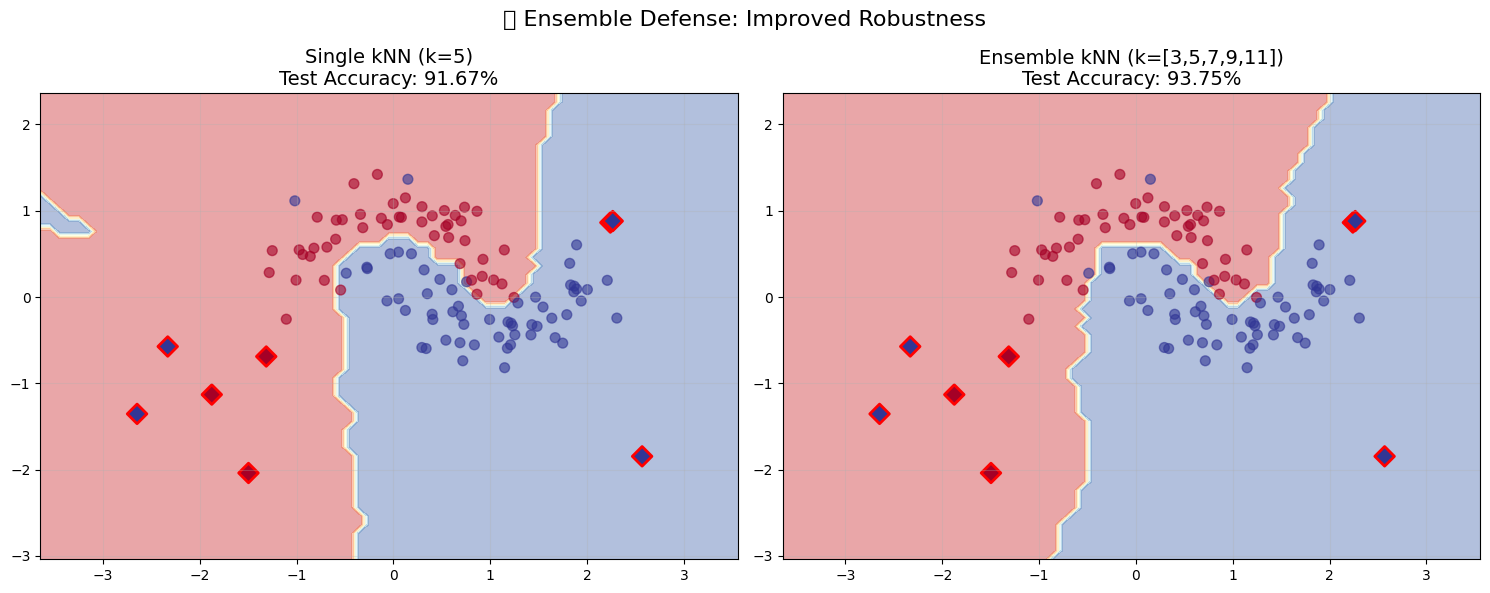


🛡️ Ensemble Benefits:
- Reduces impact of outliers
- More stable decision boundaries
- Harder to attack (need to fool multiple models)


In [10]:
# 🤝 Ensemble Defense
class EnsembleKNN:
    def __init__(self, k_values=[3, 5, 7, 9], aggregation='weighted'):
        self.k_values = k_values
        self.aggregation = aggregation
        self.models = {}

    def fit(self, X, y):
        for k in self.k_values:
            self.models[k] = KNeighborsClassifier(n_neighbors=k)
            self.models[k].fit(X, y)

    def predict(self, X):
        predictions = []
        weights = []

        for k, model in self.models.items():
            pred = model.predict(X)
            predictions.append(pred)

            # Weight by k (larger k = more stable)
            weights.append(np.sqrt(k))

        predictions = np.array(predictions)
        weights = np.array(weights) / np.sum(weights)

        if self.aggregation == 'weighted':
            # Weighted voting
            weighted_pred = np.average(predictions, axis=0, weights=weights)
            return np.round(weighted_pred).astype(int)
        else:
            # Simple majority
            return np.round(np.mean(predictions, axis=0)).astype(int)

# Interactive ensemble demonstration
def demonstrate_ensemble_defense():
    # Generate data with outliers
    X, y = make_moons(n_samples=150, noise=0.2, random_state=42)

    # Add some outliers
    n_outliers = 10
    outlier_X = np.random.uniform(-3, 3, (n_outliers, 2))
    outlier_y = np.random.randint(0, 2, n_outliers)

    X = np.vstack([X, outlier_X])
    y = np.hstack([y, outlier_y])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    # Train models
    single_knn = KNeighborsClassifier(n_neighbors=5)
    single_knn.fit(X_train, y_train)

    ensemble_knn = EnsembleKNN(k_values=[3, 5, 7, 9, 11])
    ensemble_knn.fit(X_train, y_train)

    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Single model
    ax = axes[0]
    visualize_model_robustness(ax, single_knn, X_train, y_train, X_test, y_test,
                              "Single kNN (k=5)")

    # Ensemble model
    ax = axes[1]
    visualize_model_robustness(ax, ensemble_knn, X_train, y_train, X_test, y_test,
                              "Ensemble kNN (k=[3,5,7,9,11])")

    plt.suptitle('🤝 Ensemble Defense: Improved Robustness', fontsize=16)
    plt.tight_layout()
    plt.show()

    print("\n🛡️ Ensemble Benefits:")
    print("- Reduces impact of outliers")
    print("- More stable decision boundaries")
    print("- Harder to attack (need to fool multiple models)")

def visualize_model_robustness(ax, model, X_train, y_train, X_test, y_test, title):
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')

    # Identify outliers (points far from others)
    from sklearn.neighbors import LocalOutlierFactor
    lof = LocalOutlierFactor(n_neighbors=10)
    outlier_labels = lof.fit_predict(X_train)

    # Plot normal points
    normal_mask = outlier_labels == 1
    ax.scatter(X_train[normal_mask, 0], X_train[normal_mask, 1],
              c=y_train[normal_mask], cmap='RdYlBu', s=50, alpha=0.6)

    # Highlight outliers
    outlier_mask = outlier_labels == -1
    ax.scatter(X_train[outlier_mask, 0], X_train[outlier_mask, 1],
              c=y_train[outlier_mask], cmap='RdYlBu', s=100,
              marker='D', edgecolor='red', linewidth=2)

    acc = accuracy_score(y_test, model.predict(X_test))
    ax.set_title(f'{title}\nTest Accuracy: {acc:.2%}', fontsize=14)
    ax.grid(True, alpha=0.3)

demonstrate_ensemble_defense()

### Defense 2: Outlier Detection and Data Sanitization 🧹

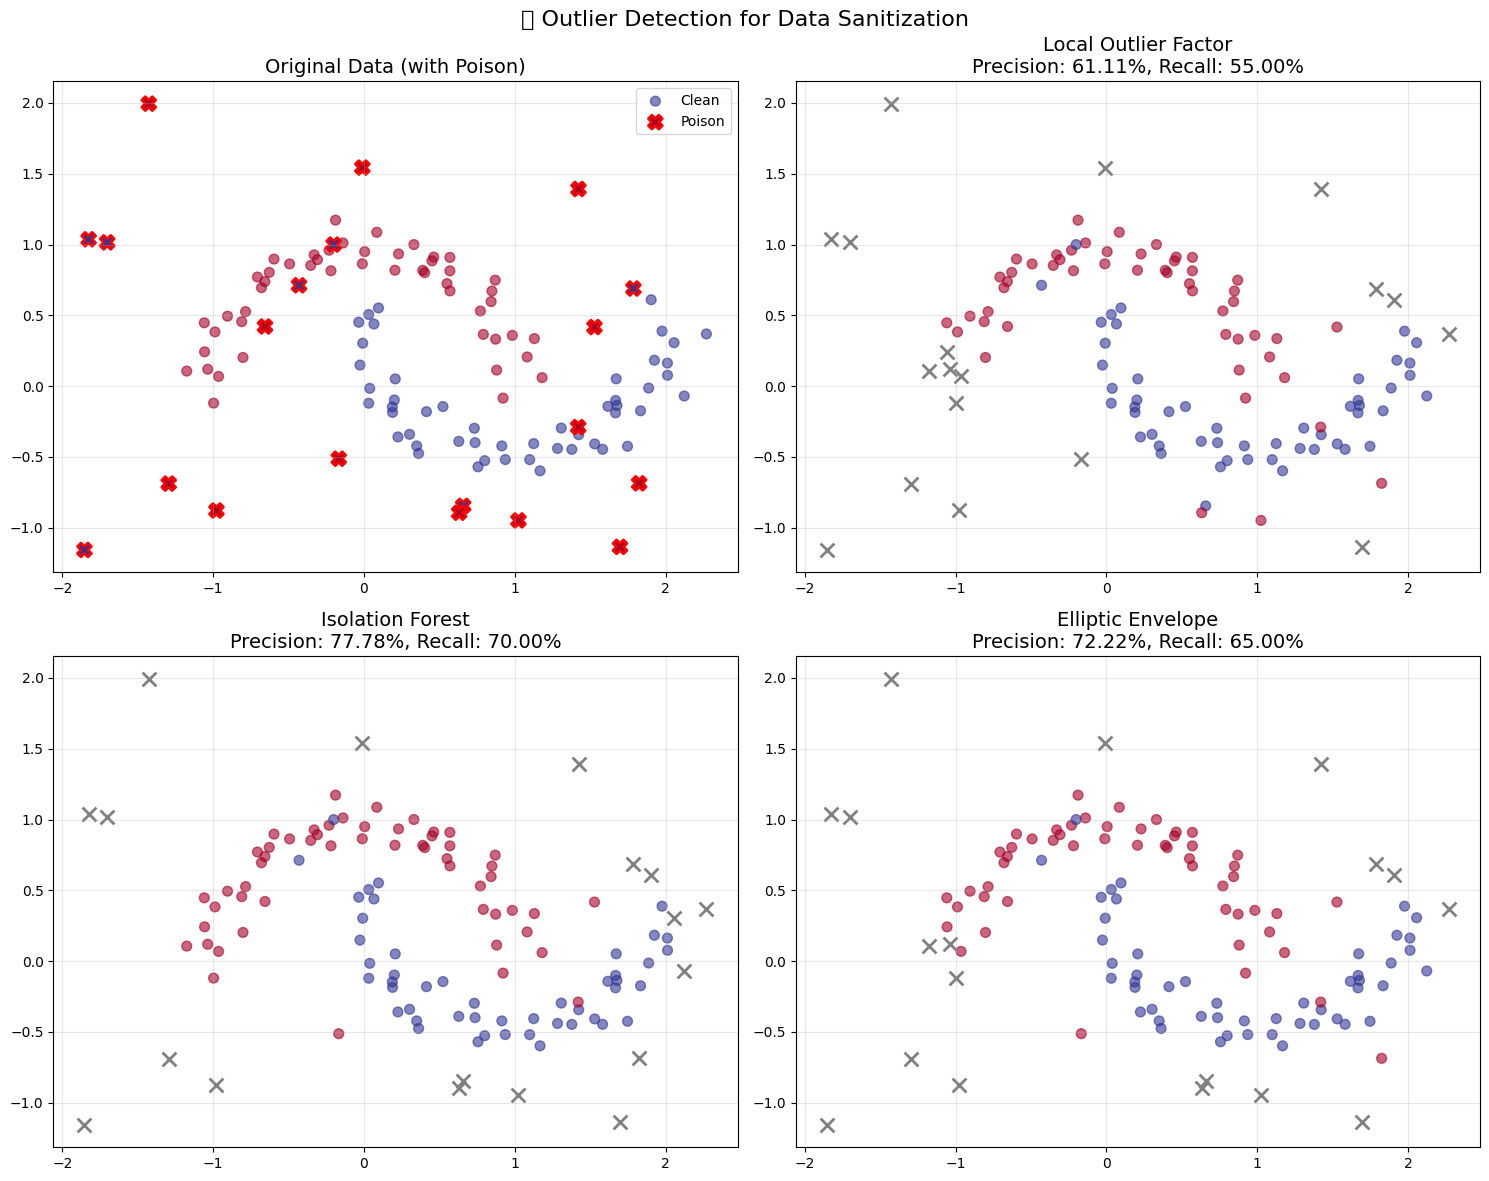


🛡️ Data Sanitization Strategy:
1. Use multiple outlier detection methods
2. Combine their outputs (e.g., majority vote)
3. Remove detected outliers before training
4. Monitor for concept drift in production


In [11]:
# 🧹 Data Sanitization Defense
def demonstrate_outlier_detection():
    # Generate clean data
    X_clean, y_clean = make_moons(n_samples=100, noise=0.1, random_state=42)

    # Add poisoned data
    n_poison = 20
    X_poison = np.random.uniform(-2, 2, (n_poison, 2))
    y_poison = np.random.randint(0, 2, n_poison)

    # Combine
    X_all = np.vstack([X_clean, X_poison])
    y_all = np.hstack([y_clean, y_poison])
    is_poison = np.hstack([np.zeros(len(X_clean)), np.ones(len(X_poison))])

    # Outlier detection methods
    from sklearn.ensemble import IsolationForest
    from sklearn.neighbors import LocalOutlierFactor
    from sklearn.covariance import EllipticEnvelope

    detectors = [
        ('Local Outlier Factor', LocalOutlierFactor(contamination=0.15)),
        ('Isolation Forest', IsolationForest(contamination=0.15, random_state=42)),
        ('Elliptic Envelope', EllipticEnvelope(contamination=0.15, random_state=42))
    ]

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    # Original poisoned data
    ax = axes[0]
    ax.scatter(X_clean[:, 0], X_clean[:, 1], c=y_clean,
              cmap='RdYlBu', s=50, alpha=0.6, label='Clean')
    ax.scatter(X_poison[:, 0], X_poison[:, 1], c=y_poison,
              cmap='RdYlBu', s=100, marker='X',
              edgecolor='red', linewidth=2, label='Poison')
    ax.set_title('Original Data (with Poison)', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Apply detectors
    for idx, (name, detector) in enumerate(detectors):
        ax = axes[idx + 1]

        # Detect outliers
        if name == 'Local Outlier Factor':
            outlier_pred = detector.fit_predict(X_all)
        else:
            outlier_pred = detector.fit_predict(X_all)

        # Calculate performance
        detected_outliers = outlier_pred == -1
        true_positives = np.sum(detected_outliers & (is_poison == 1))
        false_positives = np.sum(detected_outliers & (is_poison == 0))

        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / n_poison

        # Visualize
        clean_mask = outlier_pred == 1
        outlier_mask = outlier_pred == -1

        ax.scatter(X_all[clean_mask, 0], X_all[clean_mask, 1],
                  c=y_all[clean_mask], cmap='RdYlBu', s=50, alpha=0.6)
        ax.scatter(X_all[outlier_mask, 0], X_all[outlier_mask, 1],
                  c='gray', s=100, marker='x', linewidth=2)

        ax.set_title(f'{name}\nPrecision: {precision:.2%}, Recall: {recall:.2%}',
                    fontsize=14)
        ax.grid(True, alpha=0.3)

    plt.suptitle('🧹 Outlier Detection for Data Sanitization', fontsize=16)
    plt.tight_layout()
    plt.show()

    print("\n🛡️ Data Sanitization Strategy:")
    print("1. Use multiple outlier detection methods")
    print("2. Combine their outputs (e.g., majority vote)")
    print("3. Remove detected outliers before training")
    print("4. Monitor for concept drift in production")

demonstrate_outlier_detection()

## Part 3: Production Security Considerations 🏭

### Key Security Measures for Production kNN Systems

🏭 Production Security Checklist for kNN Systems


📋 Input Validation:
   ✓ Validate input dimensions and types
   ✓ Check for out-of-range values
   ✓ Implement rate limiting
   ✓ Detect anomalous query patterns

📋 Model Protection:
   ✓ Use differential privacy (ε < 1 for sensitive data)
   ✓ Implement ensemble methods
   ✓ Regular model retraining with sanitized data
   ✓ Version control and rollback capabilities

📋 Monitoring:
   ✓ Track prediction confidence distributions
   ✓ Monitor for distribution drift
   ✓ Log suspicious queries
   ✓ Alert on accuracy degradation

📋 Access Control:
   ✓ API authentication (OAuth 2.0)
   ✓ Query rate limiting per user
   ✓ Audit logging of all predictions
   ✓ Encrypt model storage


💡 Remember: Security is a continuous process, not a one-time setup!

🔍 Key Metrics to Monitor:
   • Query volume trends
   • Prediction confidence distribution
   • Feature distribution shifts
   • Model accuracy over time


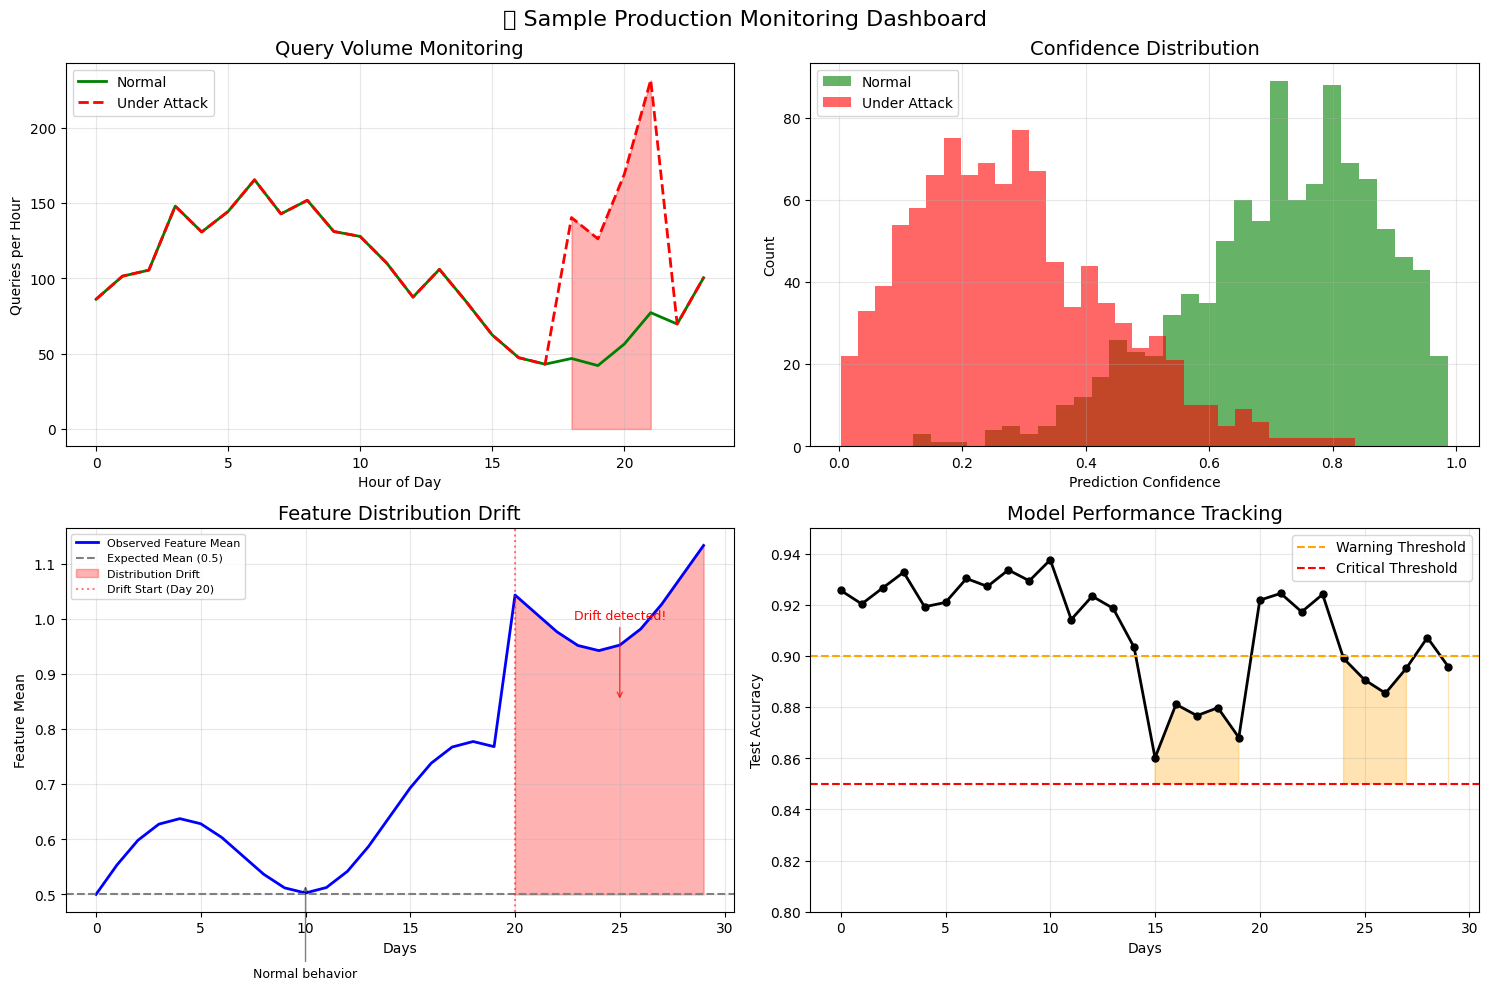

In [12]:
# 🏭 Production Security Checklist
def production_security_summary():
    checklist = [
        {"category": "Input Validation",
         "measures": [
             "Validate input dimensions and types",
             "Check for out-of-range values",
             "Implement rate limiting",
             "Detect anomalous query patterns"
         ]},
        {"category": "Model Protection",
         "measures": [
             "Use differential privacy (ε < 1 for sensitive data)",
             "Implement ensemble methods",
             "Regular model retraining with sanitized data",
             "Version control and rollback capabilities"
         ]},
        {"category": "Monitoring",
         "measures": [
             "Track prediction confidence distributions",
             "Monitor for distribution drift",
             "Log suspicious queries",
             "Alert on accuracy degradation"
         ]},
        {"category": "Access Control",
         "measures": [
             "API authentication (OAuth 2.0)",
             "Query rate limiting per user",
             "Audit logging of all predictions",
             "Encrypt model storage"
         ]}
    ]

    print("🏭 Production Security Checklist for kNN Systems\n")

    for item in checklist:
        print(f"\n📋 {item['category']}:")
        for measure in item['measures']:
            print(f"   ✓ {measure}")

    print("\n\n💡 Remember: Security is a continuous process, not a one-time setup!")
    print("\n🔍 Key Metrics to Monitor:")
    print("   • Query volume trends")
    print("   • Prediction confidence distribution")
    print("   • Feature distribution shifts")
    print("   • Model accuracy over time")

    # Sample monitoring dashboard
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Metric 1: Query volume
    ax = axes[0, 0]
    hours = np.arange(24)
    normal_queries = 100 + 50 * np.sin(hours * np.pi / 12) + np.random.normal(0, 10, 24)
    attack_queries = normal_queries.copy()
    attack_queries[18:22] *= 3  # Spike during attack

    ax.plot(hours, normal_queries, 'g-', label='Normal', linewidth=2)
    ax.plot(hours, attack_queries, 'r--', label='Under Attack', linewidth=2)
    ax.fill_between(hours[18:22], 0, attack_queries[18:22], alpha=0.3, color='red')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Queries per Hour')
    ax.set_title('Query Volume Monitoring', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Metric 2: Confidence distribution
    ax = axes[0, 1]
    normal_conf = np.random.beta(5, 2, 1000)
    attack_conf = np.random.beta(2, 5, 1000)

    ax.hist(normal_conf, bins=30, alpha=0.6, label='Normal', color='green')
    ax.hist(attack_conf, bins=30, alpha=0.6, label='Under Attack', color='red')
    ax.set_xlabel('Prediction Confidence')
    ax.set_ylabel('Count')
    ax.set_title('Confidence Distribution', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Metric 3: Feature drift - IMPROVED VERSION
    ax = axes[1, 0]
    days = np.arange(30)
    feature_mean = 0.5 + 0.01 * days + 0.1 * np.sin(days * np.pi / 7)
    feature_mean[20:] += 0.3  # Drift

    # Plot with proper labels
    ax.plot(days, feature_mean, 'b-', linewidth=2, label='Observed Feature Mean')
    ax.axhline(y=0.5, color='gray', linestyle='--', label='Expected Mean (0.5)')
    ax.fill_between(days[20:], 0.5, feature_mean[20:], alpha=0.3, color='red',
                    label='Distribution Drift')

    # Add vertical line to mark drift start
    ax.axvline(x=20, color='red', linestyle=':', alpha=0.5, label='Drift Start (Day 20)')

    # Add annotations
    ax.annotate('Normal behavior', xy=(10, 0.52), xytext=(10, 0.35),
                arrowprops=dict(arrowstyle='->', alpha=0.5),
                fontsize=9, ha='center')

    ax.annotate('Drift detected!', xy=(25, 0.85), xytext=(25, 1.0),
                arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                fontsize=9, ha='center', color='red')

    ax.set_xlabel('Days')
    ax.set_ylabel('Feature Mean')
    ax.set_title('Feature Distribution Drift', fontsize=14)
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)

    # Metric 4: Model accuracy
    ax = axes[1, 1]
    days = np.arange(30)
    accuracy = 0.92 + np.random.normal(0, 0.01, 30)
    accuracy[15:20] -= 0.05  # Attack period
    accuracy[25:] -= 0.03  # Degradation

    ax.plot(days, accuracy, 'ko-', linewidth=2, markersize=5)
    ax.axhline(y=0.9, color='orange', linestyle='--', label='Warning Threshold')
    ax.axhline(y=0.85, color='red', linestyle='--', label='Critical Threshold')
    ax.fill_between(days, 0.85, accuracy, where=(accuracy < 0.9),
                   alpha=0.3, color='orange')
    ax.set_xlabel('Days')
    ax.set_ylabel('Test Accuracy')
    ax.set_title('Model Performance Tracking', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0.8, 0.95)

    plt.suptitle('📊 Sample Production Monitoring Dashboard', fontsize=16)
    plt.tight_layout()
    plt.show()

production_security_summary()

## 🎓 Lab Summary

### Key Takeaways

1. **kNN's Unique Vulnerabilities**:
   - Stores all training data (privacy risk)
   - Distance-based decisions (manipulation attacks)
   - No model parameters (harder to detect tampering)

2. **Attack Landscape**:
   - **Label Flipping**: Target boundary points for maximum impact
   - **Membership Inference**: Exploit distance to training data
   - **Model Extraction**: Reconstruct training data through queries
   - **Distance Manipulation**: Exploit different metrics
   - **Byzantine Attacks**: Poison distributed systems

3. **Defense Strategies**:
   - **Differential Privacy**: Add noise for privacy (ε ≈ 1)
   - **Ensemble Methods**: Multiple k values for robustness
   - **Data Sanitization**: Detect and remove outliers
   - **Robust Distances**: Learn better metrics

4. **Production Considerations**:
   - Input validation and rate limiting
   - Continuous monitoring for anomalies
   - Regular retraining with clean data
   - Comprehensive logging and alerting

### 🚀 Next Steps

1. **Experiment**: Try combining multiple defenses
2. **Implement**: Add these defenses to your kNN systems
3. **Monitor**: Set up production monitoring dashboards
4. **Stay Updated**: Follow latest research on kNN security

### 📚 Further Reading

- "ASK: Adversarial Soft k-Nearest Neighbor Attack and Defense" (NeurIPS 2022)
- "Certified Robustness of Nearest Neighbors" (AAAI 2021)
- "Privacy-Preserving k-NN for Small and Large Data Sets" (ICDM 2019)

---

**Remember**: Security is not about perfect protection, but about making attacks more expensive than they're worth! 🛡️